In [61]:
#install pmdarima module
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [62]:
#import modules 
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima 
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


energy_df = pd.read_csv("historic_demand_2009_2024_noNaN.csv")
energy_df.head()

settlement_date  settlement_period period_hour     nd    tsd  \
0  2009-01-01 00:00:00                  1     0:00:00  37910  38704   
1  2009-01-01 00:30:00                  2     0:30:00  38047  38964   
2  2009-01-01 01:00:00                  3     1:00:00  37380  38651   
3  2009-01-01 01:30:00                  4     1:30:00  36426  37775   
4  2009-01-01 02:00:00                  5     2:00:00  35687  37298   

   england_wales_demand  embedded_wind_generation  embedded_wind_capacity  \
0                 33939                        54                    1403   
1                 34072                        53                    1403   
2                 33615                        53                    1403   
3                 32526                        50                    1403   
4                 31877                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
0                          0                        0            0   
1                          0                        0            0   
2                          0                        0            0   
3                          0                        0            0   
4                          0                        0            0   

   pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
0                    33      2002          0             0        -161   
1                   157      2002          0             0        -160   
2                   511      2002          0             0        -160   
3                   589      1772          0             0        -160   
4                   851      1753          0             0        -160   

   east_west_flow  nemo_flow  is_holiday  
0               0          0           1  
1               0          0           1  
2               0          0           1  
3               0          0           1  
4               0          0           1

In [63]:
#Check for duplicate values
energy_df.duplicated().sum()

0

In [64]:
#Check for missing values
energy_df.isna().sum()

settlement_date              0
settlement_period            0
period_hour                  0
nd                           0
tsd                          0
england_wales_demand         0
embedded_wind_generation     0
embedded_wind_capacity       0
embedded_solar_generation    0
embedded_solar_capacity      0
non_bm_stor                  0
pump_storage_pumping         0
ifa_flow                     0
ifa2_flow                    0
britned_flow                 0
moyle_flow                   0
east_west_flow               0
nemo_flow                    0
is_holiday                   0
dtype: int64

In [65]:
#Check information for each variable
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271456 entries, 0 to 271455
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   settlement_date            271456 non-null  object
 1   settlement_period          271456 non-null  int64 
 2   period_hour                271456 non-null  object
 3   nd                         271456 non-null  int64 
 4   tsd                        271456 non-null  int64 
 5   england_wales_demand       271456 non-null  int64 
 6   embedded_wind_generation   271456 non-null  int64 
 7   embedded_wind_capacity     271456 non-null  int64 
 8   embedded_solar_generation  271456 non-null  int64 
 9   embedded_solar_capacity    271456 non-null  int64 
 10  non_bm_stor                271456 non-null  int64 
 11  pump_storage_pumping       271456 non-null  int64 
 12  ifa_flow                   271456 non-null  int64 
 13  ifa2_flow                  271456 non-null  

In [66]:
# A dictionary comprehension for storing the unique values in each column
unique_info = {col: energy_df[col].unique() for col in energy_df.columns}
unique_info

{'settlement_date': array(['2009-01-01 00:00:00', '2009-01-01 00:30:00',
        '2009-01-01 01:00:00', ..., '2024-07-11 22:30:00',
        '2024-07-11 23:00:00', '2024-07-11 23:30:00'], dtype=object),
 'settlement_period': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 'period_hour': array(['0:00:00', '0:30:00', '1:00:00', '1:30:00', '2:00:00', '2:30:00',
        '3:00:00', '3:30:00', '4:00:00', '4:30:00', '5:00:00', '5:30:00',
        '6:00:00', '6:30:00', '7:00:00', '7:30:00', '8:00:00', '8:30:00',
        '9:00:00', '9:30:00', '10:00:00', '10:30:00', '11:00:00',
        '11:30:00', '12:00:00', '12:30:00', '13:00:00', '13:30:00',
        '14:00:00', '14:30:00', '15:00:00', '15:30:00', '16:00:00',
        '16:30:00', '17:00:00', '17:30:00', '18:00:00', '18:30:00',
        '19:00:00', '19:30:00', '20:00:00', '20:30:0

In [67]:
#extract dates from the settlement date column
energy_df['dates'] = pd.to_datetime(energy_df['settlement_date']).dt.date

#Create a year column containing all the years in the settlement column.
energy_df['year'] = pd.to_datetime(energy_df['settlement_date']).dt.year
energy_df.head()

settlement_date  settlement_period period_hour     nd    tsd  \
0  2009-01-01 00:00:00                  1     0:00:00  37910  38704   
1  2009-01-01 00:30:00                  2     0:30:00  38047  38964   
2  2009-01-01 01:00:00                  3     1:00:00  37380  38651   
3  2009-01-01 01:30:00                  4     1:30:00  36426  37775   
4  2009-01-01 02:00:00                  5     2:00:00  35687  37298   

   england_wales_demand  embedded_wind_generation  embedded_wind_capacity  \
0                 33939                        54                    1403   
1                 34072                        53                    1403   
2                 33615                        53                    1403   
3                 32526                        50                    1403   
4                 31877                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
0                          0                        0            0   
1                          0                        0            0   
2                          0                        0            0   
3                          0                        0            0   
4                          0                        0            0   

   pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
0                    33      2002          0             0        -161   
1                   157      2002          0             0        -160   
2                   511      2002          0             0        -160   
3                   589      1772          0             0        -160   
4                   851      1753          0             0        -160   

   east_west_flow  nemo_flow  is_holiday       dates  year  
0               0          0           1  2009-01-01  2009  
1               0          0           1  2009-01-01  2009  
2               0          0           1  2009-01-01  2009  
3               0          0           1  2009-01-01  2009  
4               0          0           1  2009-01-01  2009

In [68]:
#Create a subset of the energy_df dataframe to contain only the variables to be used.
energy_nd = energy_df[['settlement_date','period_hour','nd','embedded_wind_generation','embedded_wind_capacity','embedded_solar_generation','embedded_solar_capacity','ifa_flow','ifa2_flow','britned_flow','moyle_flow','east_west_flow','nemo_flow','is_holiday','dates','year']]

In [69]:
#Reset the index of the dataframe setting the date column as the index
energy_nd.set_index(['dates'],inplace=True)
energy_nd.head()

settlement_date period_hour     nd  embedded_wind_generation  \
dates                                                                          
2009-01-01  2009-01-01 00:00:00     0:00:00  37910                        54   
2009-01-01  2009-01-01 00:30:00     0:30:00  38047                        53   
2009-01-01  2009-01-01 01:00:00     1:00:00  37380                        53   
2009-01-01  2009-01-01 01:30:00     1:30:00  36426                        50   
2009-01-01  2009-01-01 02:00:00     2:00:00  35687                        50   

            embedded_wind_capacity  embedded_solar_generation  \
dates                                                           
2009-01-01                    1403                          0   
2009-01-01                    1403                          0   
2009-01-01                    1403                          0   
2009-01-01                    1403                          0   
2009-01-01                    1403                          0   

            embedded_solar_capacity  ifa_flow  ifa2_flow  britned_flow  \
dates                                                                    
2009-01-01                        0      2002          0             0   
2009-01-01                        0      2002          0             0   
2009-01-01                        0      2002          0             0   
2009-01-01                        0      1772          0             0   
2009-01-01                        0      1753          0             0   

            moyle_flow  east_west_flow  nemo_flow  is_holiday  year  
dates                                                                
2009-01-01        -161               0          0           1  2009  
2009-01-01        -160               0          0           1  2009  
2009-01-01        -160               0          0           1  2009  
2009-01-01        -160               0          0           1  2009  
2009-01-01        -160               0          0           1  2009

In [70]:
energy_sub = energy_df[['settlement_date','period_hour','tsd','embedded_wind_generation','embedded_wind_capacity','embedded_solar_generation','embedded_solar_capacity','ifa_flow','ifa2_flow','britned_flow','moyle_flow','east_west_flow','nemo_flow','is_holiday','dates','year']]

energy_sub.set_index(['dates'],inplace=True)
energy_sub.head()

settlement_date period_hour    tsd  embedded_wind_generation  \
dates                                                                          
2009-01-01  2009-01-01 00:00:00     0:00:00  38704                        54   
2009-01-01  2009-01-01 00:30:00     0:30:00  38964                        53   
2009-01-01  2009-01-01 01:00:00     1:00:00  38651                        53   
2009-01-01  2009-01-01 01:30:00     1:30:00  37775                        50   
2009-01-01  2009-01-01 02:00:00     2:00:00  37298                        50   

            embedded_wind_capacity  embedded_solar_generation  \
dates                                                           
2009-01-01                    1403                          0   
2009-01-01                    1403                          0   
2009-01-01                    1403                          0   
2009-01-01                    1403                          0   
2009-01-01                    1403                          0   

            embedded_solar_capacity  ifa_flow  ifa2_flow  britned_flow  \
dates                                                                    
2009-01-01                        0      2002          0             0   
2009-01-01                        0      2002          0             0   
2009-01-01                        0      2002          0             0   
2009-01-01                        0      1772          0             0   
2009-01-01                        0      1753          0             0   

            moyle_flow  east_west_flow  nemo_flow  is_holiday  year  
dates                                                                
2009-01-01        -161               0          0           1  2009  
2009-01-01        -160               0          0           1  2009  
2009-01-01        -160               0          0           1  2009  
2009-01-01        -160               0          0           1  2009  
2009-01-01        -160               0          0           1  2009

In [71]:
#Create a column containing all the months from in the settlement date column
energy_sub['months'] = pd.to_datetime(energy_sub['settlement_date']).dt.month

#Create a column containing all the weekdays in the settlement date column
energy_sub['weeks'] = pd.to_datetime(energy_sub['settlement_date']).dt.weekday

#Create a column containing all the days in the settlement date column
energy_sub['days'] = pd.to_datetime(energy_sub['settlement_date']).dt.day

#Create a column containing all the hours from in the settlement date column
energy_sub['hours'] = pd.to_datetime(energy_sub['settlement_date']).dt.hour

In [72]:
#Descriptive statistics showing the count, mean, max, min and standard deviation
energy_sub.describe().transpose().round(2)

count      mean      std      min       25%  \
tsd                        271456.0  32821.52  7596.53  16513.0  26752.00   
embedded_wind_generation   271456.0   1260.42   959.33      0.0    546.00   
embedded_wind_capacity     271456.0   4397.96  1949.58   1403.0   2092.00   
embedded_solar_generation  271456.0    861.43  1680.90      0.0      0.00   
embedded_solar_capacity    271456.0   8459.54  5746.39      0.0   1999.75   
ifa_flow                   271456.0    920.13  1077.07  -2056.0    239.00   
ifa2_flow                  271456.0     46.14   347.76  -1030.0      0.00   
britned_flow               271456.0    513.77   534.66  -1215.0      0.00   
moyle_flow                 271456.0   -120.82   228.99   -505.0   -291.00   
east_west_flow             271456.0    -43.99   259.84   -585.0   -187.00   
nemo_flow                  271456.0    168.24   412.84  -1022.0      0.00   
is_holiday                 271456.0      0.02     0.15      0.0      0.00   
year                       271456.0   2016.29     4.48   2009.0   2012.00   
months                     271456.0      6.43     3.45      1.0      3.00   
weeks                      271456.0      3.00     2.00      0.0      1.00   
days                       271456.0     15.71     8.79      1.0      8.00   
hours                      271456.0     11.50     6.92      0.0      5.00   

                               50%      75%      max  
tsd                        31951.0  38258.0  60147.0  
embedded_wind_generation    1008.0   1713.0   5587.0  
embedded_wind_capacity      4781.0   6527.0   6574.0  
embedded_solar_generation      0.0    858.0  10700.0  
embedded_solar_capacity    11433.0  13080.0  16445.0  
ifa_flow                    1191.0   1895.0   2066.0  
ifa2_flow                      0.0      0.0   1016.0  
britned_flow                 738.0    994.0   1143.0  
moyle_flow                  -141.0     31.0    499.0  
east_west_flow                 0.0      0.0    504.0  
nemo_flow                      0.0    226.0   1033.0  
is_holiday                     0.0      0.0      1.0  
year                        2016.0   2020.0   2024.0  
months                         6.0      9.0     12.0  
weeks                          3.0      5.0      6.0  
days                          16.0     23.0     31.0  
hours                         11.0     17.0     23.0

In [73]:
#Subset for import and export values
imports_data = energy_sub[(energy_sub['ifa_flow']>0) | (energy_sub['ifa2_flow']>0)| (energy_sub['britned_flow']>0)| (energy_sub['moyle_flow']>0)|(energy_sub['east_west_flow']>0)|(energy_sub['nemo_flow']>0)]
 

#Subset for exports
exports_data =energy_sub[(energy_sub['ifa_flow']<0) | (energy_sub['ifa2_flow']<0)| (energy_sub['britned_flow']<0)| (energy_sub['moyle_flow']<0)|(energy_sub['east_west_flow']<0)|(energy_sub['nemo_flow']<0)]

Text(0.5, 1.0, 'Electricity Demand vs Year Based on Interconnector flow Imports')

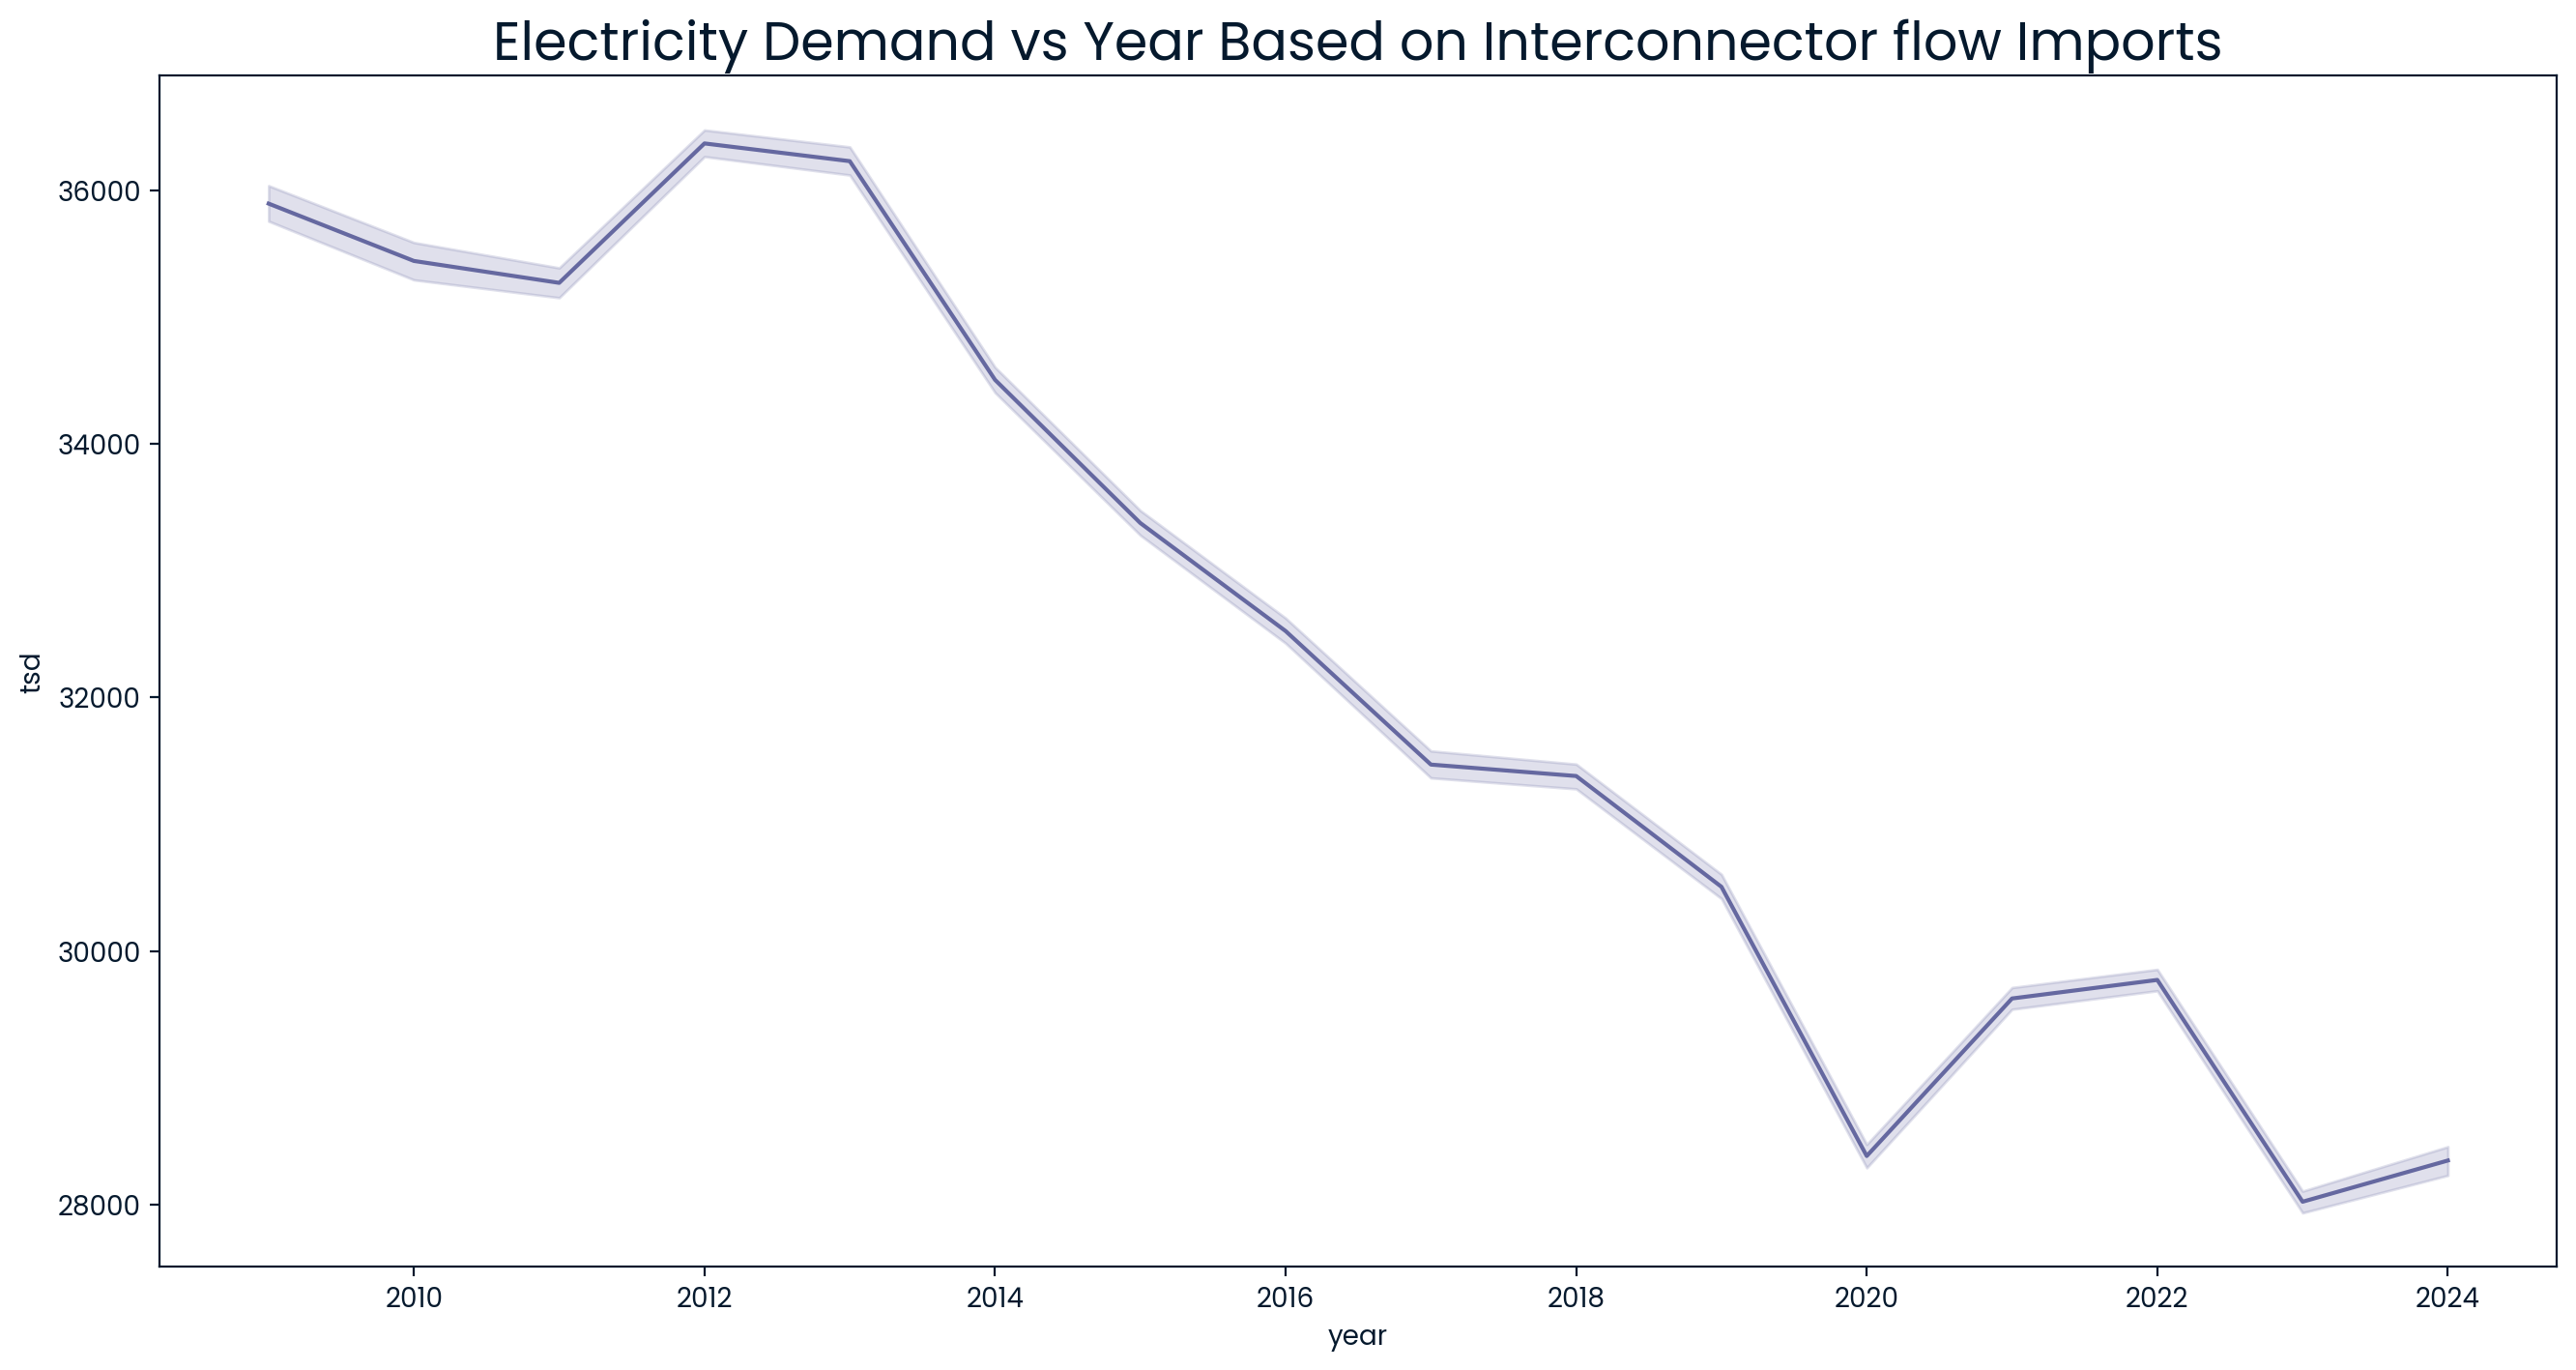

In [74]:
#Energy consumption Versus year visualization for imports
plt.figure(figsize=(16,8))
sns.lineplot(x=imports_data['year'],y=imports_data['tsd'],data=energy_sub)
plt.title('Electricity Demand vs Year Based on Interconnector flow Imports',fontsize=20)

Text(0.5, 1.0, 'Electricity Demand vs Year Based on Interconnector flow Exports')

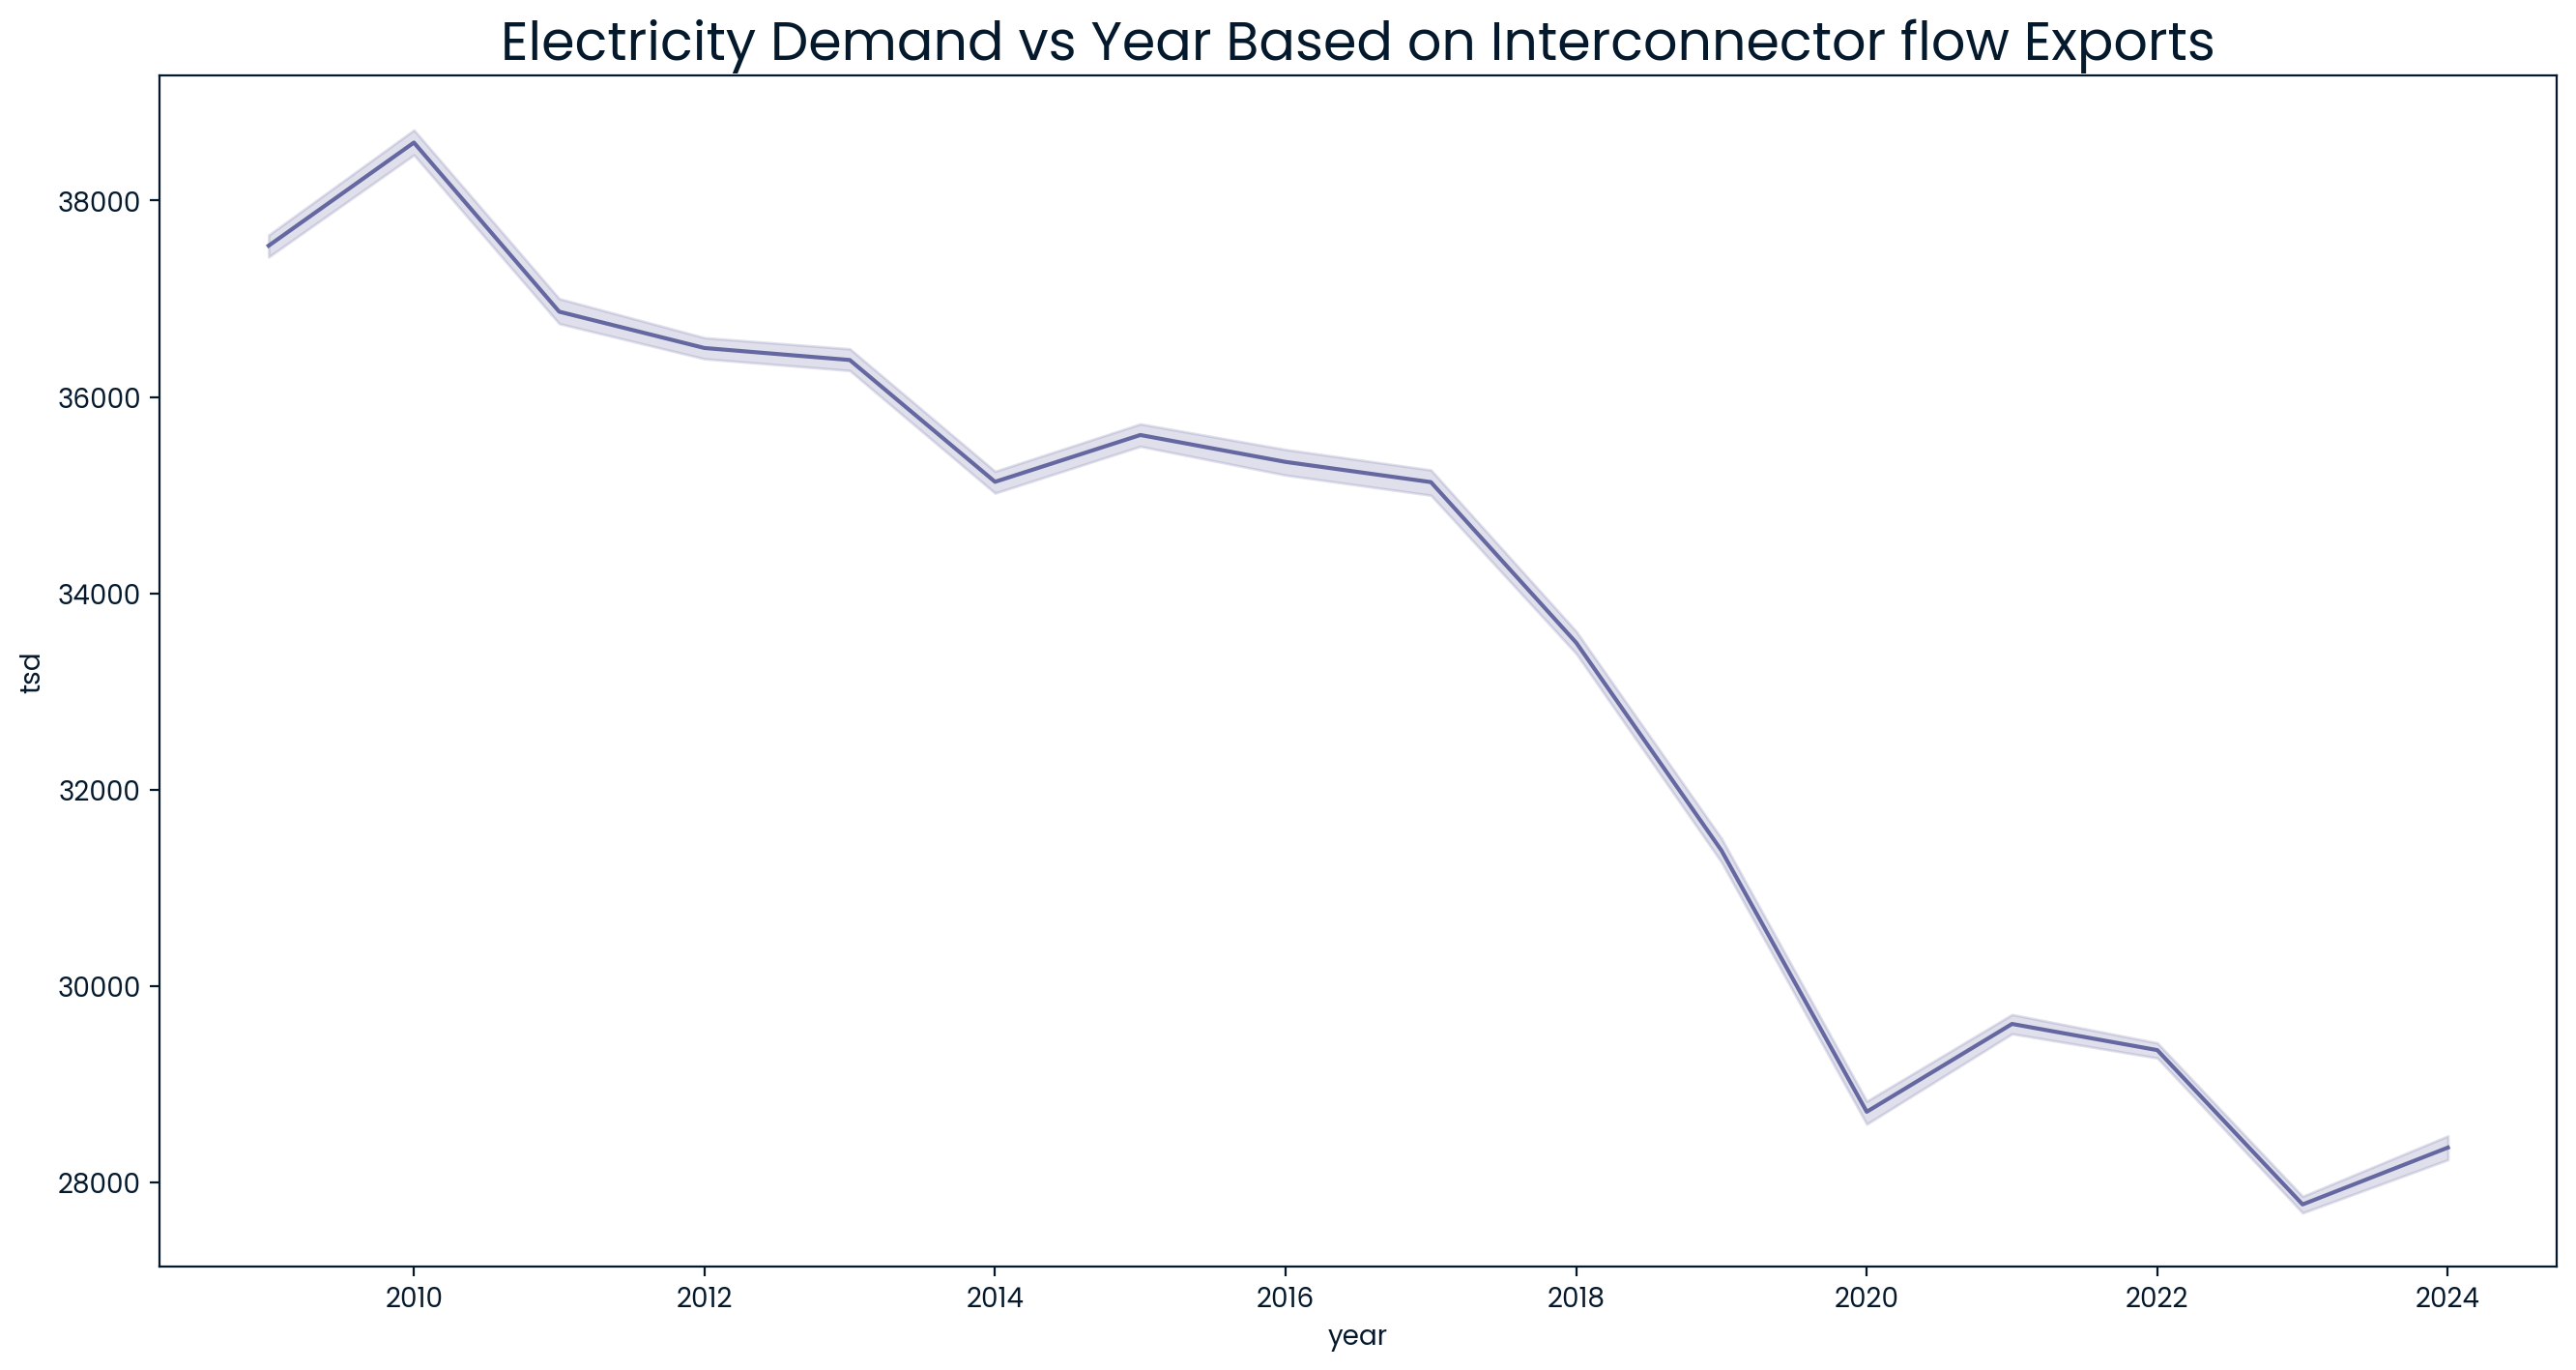

In [75]:
#Energy consumption Versus year visualization for exports
plt.figure(figsize=(16,8))
sns.lineplot(x=exports_data['year'],y=exports_data['tsd'],data=energy_sub)
plt.title('Electricity Demand vs Year Based on Interconnector flow Exports',fontsize=20)

Text(0.5, 1.0, 'Electricity Demand vs Time')

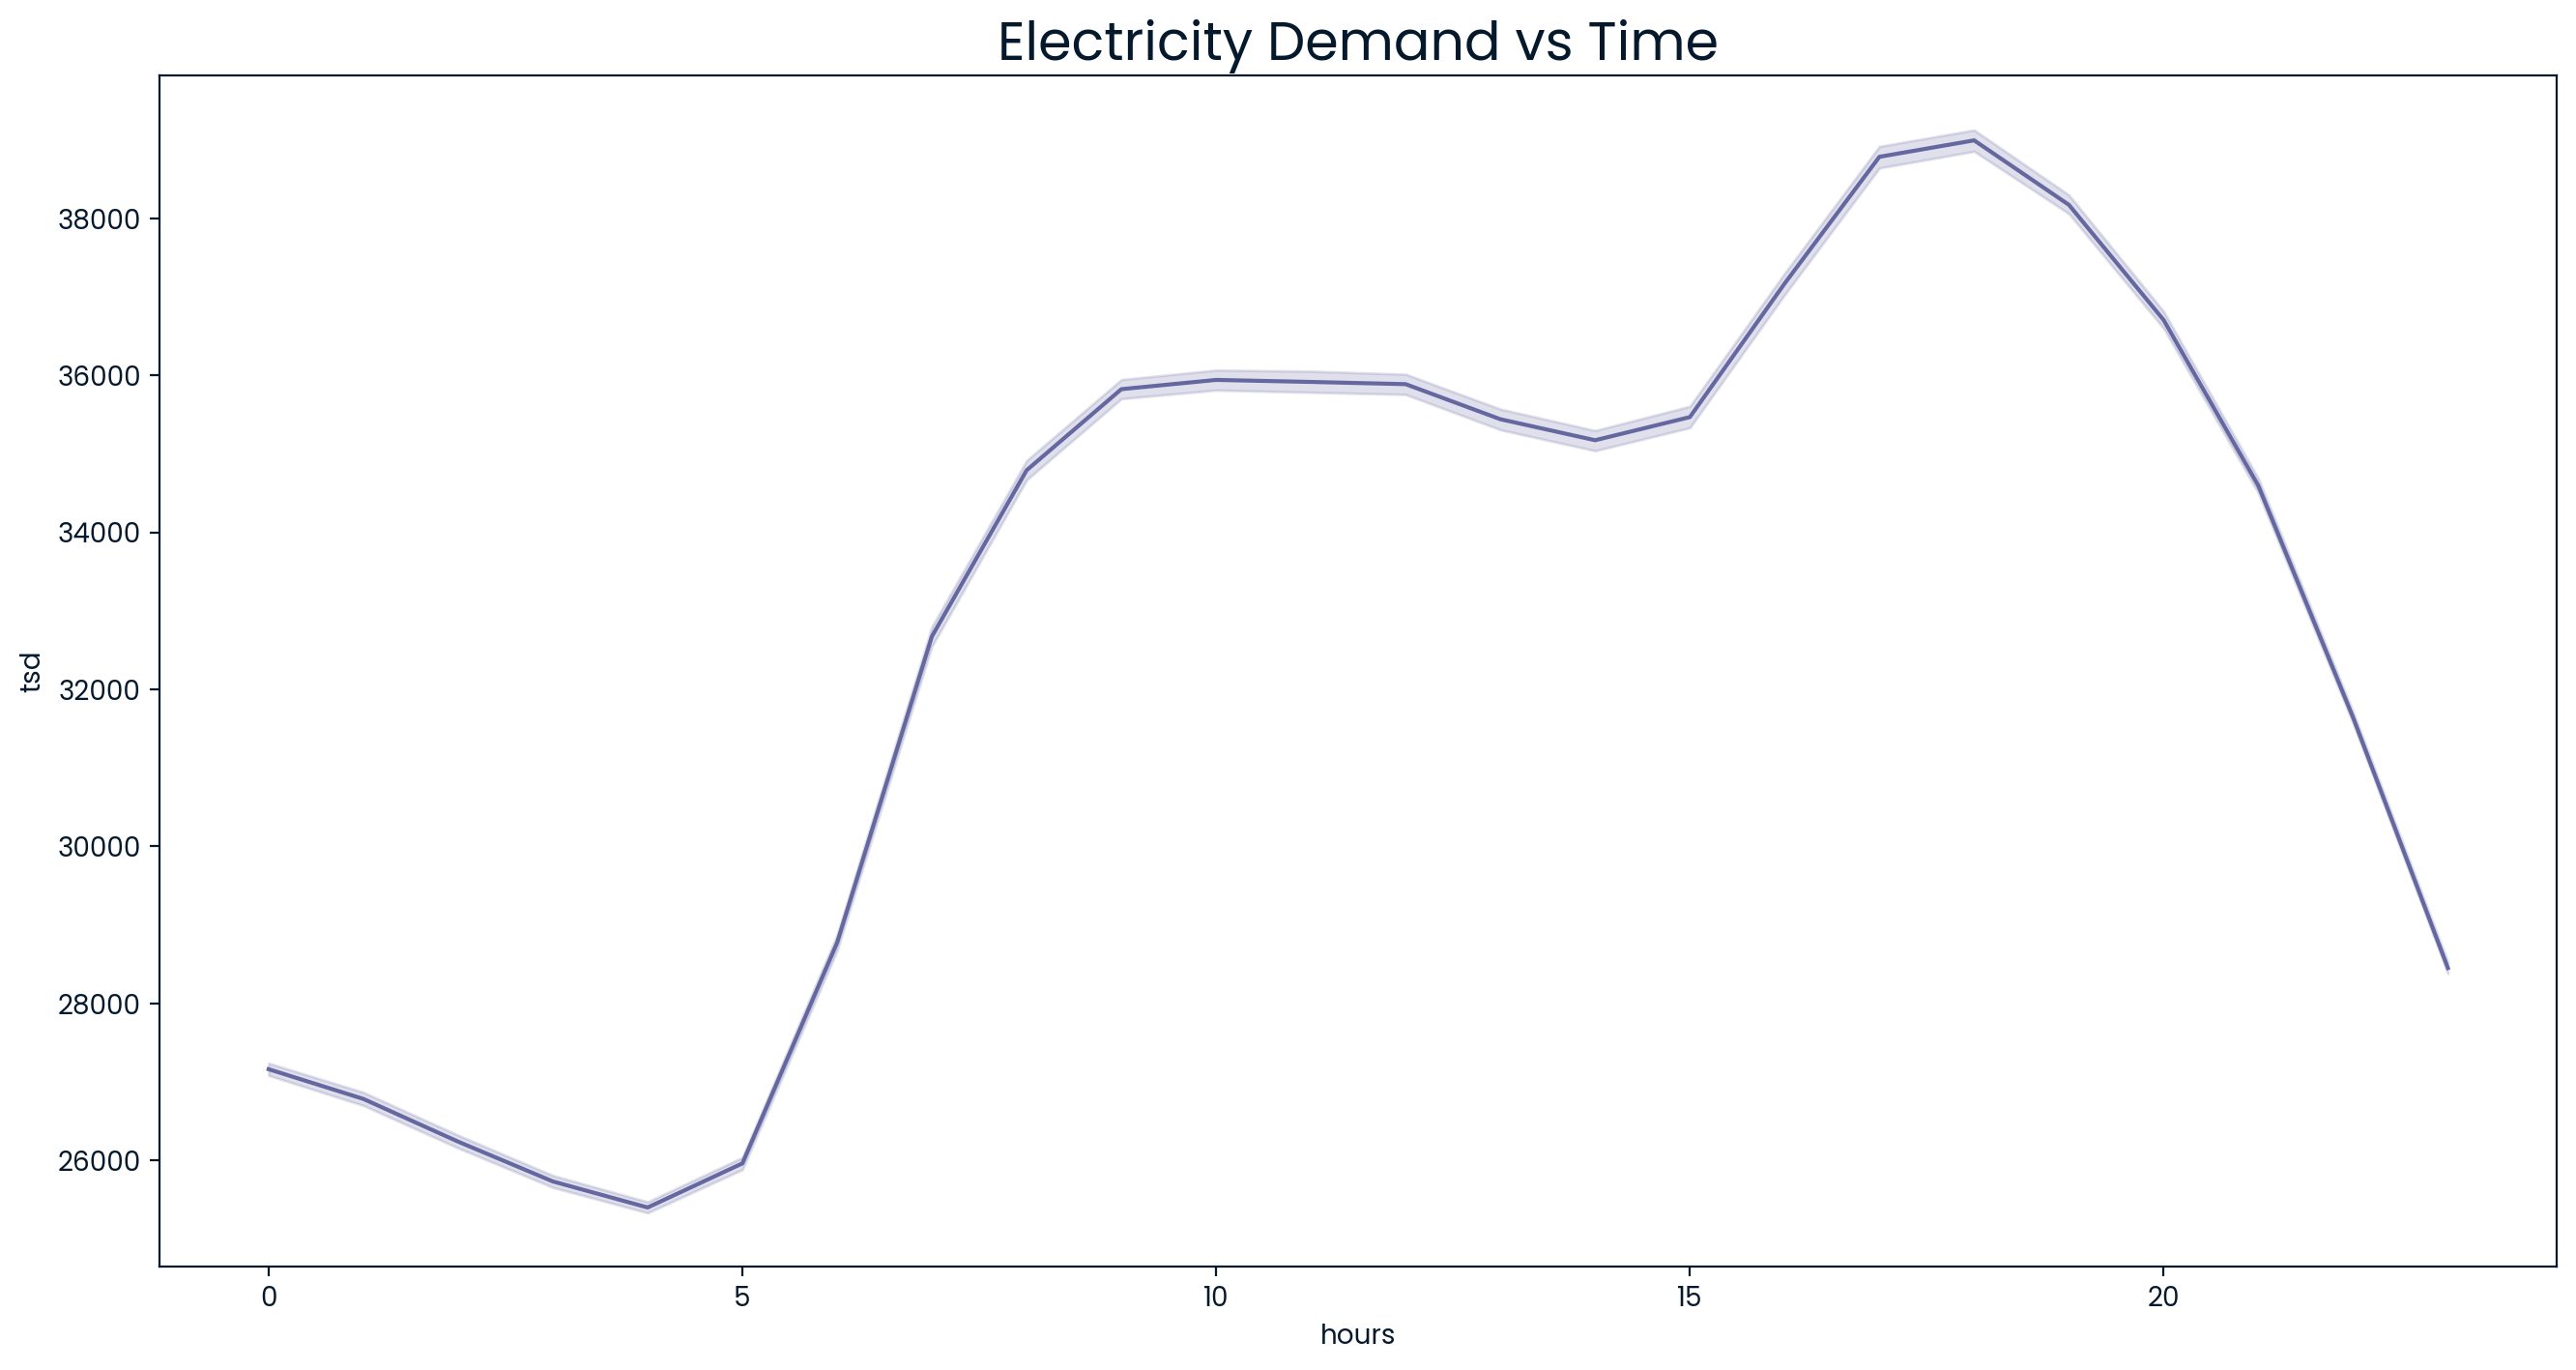

In [76]:
#Energy consumption Versus time visualization
plt.figure(figsize=(16,8))
sns.lineplot(x=energy_sub['hours'],y=energy_sub['tsd'],data=energy_sub)
plt.title('Electricity Demand vs Time',fontsize=20)

In [77]:
# Ensure the index is a DatetimeIndex
energy_sub.index = pd.to_datetime(energy_sub.index)
energy_sub['period_hour'] = pd.to_datetime(energy_sub['period_hour'])
energy_sub['settlement_date'] = pd.to_datetime(energy_sub['settlement_date'])

# Resample dataset For Month Frequency
avg_month = energy_sub.resample('M').mean()
avg_month.head()

settlement_date                   period_hour  \
dates                                                                    
2009-01-31 2009-01-16 11:45:00.000000000 2024-08-17 11:45:00.000000000   
2009-02-28 2009-02-14 23:45:00.000000000 2024-08-17 11:45:00.000000000   
2009-03-31 2009-03-16 11:18:52.570659584 2024-08-17 11:44:04.279946240   
2009-04-30 2009-04-15 23:45:00.000000000 2024-08-17 11:45:00.000000000   
2009-05-31 2009-05-16 11:45:00.000000000 2024-08-17 11:45:00.000000000   

                     tsd  embedded_wind_generation  embedded_wind_capacity  \
dates                                                                        
2009-01-31  44154.180108                594.384409             1403.000000   
2009-02-28  43317.789435                450.502232             1405.000000   
2009-03-31  39532.255047                677.549125             1419.000000   
2009-04-30  35285.631250                459.581250             1612.730556   
2009-05-31  33647.017473                736.771505             1672.919355   

            embedded_solar_generation  embedded_solar_capacity     ifa_flow  \
dates                                                                         
2009-01-31                        0.0                      0.0   109.374328   
2009-02-28                        0.0                      0.0   318.936012   
2009-03-31                        0.0                      0.0   449.471063   
2009-04-30                        0.0                      0.0  1248.881250   
2009-05-31                        0.0                      0.0  1722.575269   

            ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
dates                                                                        
2009-01-31        0.0           0.0 -130.383737             0.0        0.0   
2009-02-28        0.0           0.0 -204.177827             0.0        0.0   
2009-03-31        0.0           0.0 -208.637954             0.0        0.0   
2009-04-30        0.0           0.0 -231.459722             0.0        0.0   
2009-05-31        0.0           0.0 -216.769489             0.0        0.0   

            is_holiday    year  months     weeks       days      hours  
dates                                                                   
2009-01-31    0.032258  2009.0     1.0  3.096774  16.000000  11.500000  
2009-02-28    0.000000  2009.0     2.0  3.000000  14.500000  11.500000  
2009-03-31    0.000000  2009.0     3.0  2.931359  15.982503  11.484522  
2009-04-30    0.066667  2009.0     4.0  2.966667  15.500000  11.500000  
2009-05-31    0.064516  2009.0     5.0  3.193548  16.000000  11.500000

In [78]:
# Resample dataset For Month Frequency for 'nd'
#Ensure the index is a DatetimeIndex
energy_nd.index = pd.to_datetime(energy_nd.index)
energy_nd['period_hour'] = pd.to_datetime(energy_nd['period_hour'])
energy_nd['settlement_date'] = pd.to_datetime(energy_nd['settlement_date'])

# Resample dataset For Month Frequency
avg_month_nd = energy_nd.resample('M').mean()
avg_month_nd.head()

settlement_date                   period_hour  \
dates                                                                    
2009-01-31 2009-01-16 11:45:00.000000000 2024-08-17 11:45:00.000000000   
2009-02-28 2009-02-14 23:45:00.000000000 2024-08-17 11:45:00.000000000   
2009-03-31 2009-03-16 11:18:52.570659584 2024-08-17 11:44:04.279946240   
2009-04-30 2009-04-15 23:45:00.000000000 2024-08-17 11:45:00.000000000   
2009-05-31 2009-05-16 11:45:00.000000000 2024-08-17 11:45:00.000000000   

                      nd  embedded_wind_generation  embedded_wind_capacity  \
dates                                                                        
2009-01-31  42499.286962                594.384409             1403.000000   
2009-02-28  41721.263393                450.502232             1405.000000   
2009-03-31  38034.520188                677.549125             1419.000000   
2009-04-30  34244.037500                459.581250             1612.730556   
2009-05-31  32551.792339                736.771505             1672.919355   

            embedded_solar_generation  embedded_solar_capacity     ifa_flow  \
dates                                                                         
2009-01-31                        0.0                      0.0   109.374328   
2009-02-28                        0.0                      0.0   318.936012   
2009-03-31                        0.0                      0.0   449.471063   
2009-04-30                        0.0                      0.0  1248.881250   
2009-05-31                        0.0                      0.0  1722.575269   

            ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
dates                                                                        
2009-01-31        0.0           0.0 -130.383737             0.0        0.0   
2009-02-28        0.0           0.0 -204.177827             0.0        0.0   
2009-03-31        0.0           0.0 -208.637954             0.0        0.0   
2009-04-30        0.0           0.0 -231.459722             0.0        0.0   
2009-05-31        0.0           0.0 -216.769489             0.0        0.0   

            is_holiday    year  
dates                           
2009-01-31    0.032258  2009.0  
2009-02-28    0.000000  2009.0  
2009-03-31    0.000000  2009.0  
2009-04-30    0.066667  2009.0  
2009-05-31    0.064516  2009.0

In [79]:
#Maximum Consumption
avg_month[avg_month['tsd'] == avg_month['tsd'].max()]

settlement_date         period_hour          tsd  \
dates                                                             
2010-01-31 2010-01-16 11:45:00 2024-08-17 11:45:00  45555.59543   

            embedded_wind_generation  embedded_wind_capacity  \
dates                                                          
2010-01-31                786.604839                  1786.0   

            embedded_solar_generation  embedded_solar_capacity   ifa_flow  \
dates                                                                       
2010-01-31                        0.0                      0.0 -907.25672   

            ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
dates                                                                        
2010-01-31        0.0           0.0 -315.409946             0.0        0.0   

            is_holiday    year  months     weeks  days  hours  
dates                                                          
2010-01-31    0.032258  2010.0     1.0  3.193548  16.0   11.5

In [80]:
#Minimum Consumption For tsd
avg_month[avg_month['tsd'] == avg_month['tsd'].min()]

settlement_date         period_hour           tsd  \
dates                                                              
2020-05-31 2020-05-16 11:45:00 2024-08-17 11:45:00  22610.566532   

            embedded_wind_generation  embedded_wind_capacity  \
dates                                                          
2020-05-31                    1548.0                  6527.0   

            embedded_solar_generation  embedded_solar_capacity     ifa_flow  \
dates                                                                         
2020-05-31                2650.637769                  13080.0  1160.692876   

            ifa2_flow  britned_flow  moyle_flow  east_west_flow   nemo_flow  \
dates                                                                         
2020-05-31        0.0    514.317876   42.200269      136.414651  636.272849   

            is_holiday    year  months     weeks  days  hours  
dates                                                          
2020-05-31    0.064516  2020.0     5.0  3.193548  16.0   11.5

In [81]:
# Resample dataset For Weekly Frequency
weekly = energy_sub.resample('W').mean()
weekly.head()

settlement_date         period_hour           tsd  \
dates                                                              
2009-01-04 2009-01-02 23:45:00 2024-08-17 11:45:00  40335.901042   
2009-01-11 2009-01-08 11:45:00 2024-08-17 11:45:00  46671.627976   
2009-01-18 2009-01-15 11:45:00 2024-08-17 11:45:00  43725.330357   
2009-01-25 2009-01-22 11:45:00 2024-08-17 11:45:00  43808.425595   
2009-02-01 2009-01-29 11:45:00 2024-08-17 11:45:00  44093.633929   

            embedded_wind_generation  embedded_wind_capacity  \
dates                                                          
2009-01-04                218.447917             1403.000000   
2009-01-11                454.401786             1403.000000   
2009-01-18                795.886905             1403.000000   
2009-01-25                760.247024             1403.000000   
2009-02-01                629.482143             1403.285714   

            embedded_solar_generation  embedded_solar_capacity    ifa_flow  \
dates                                                                        
2009-01-04                        0.0                      0.0  790.239583   
2009-01-11                        0.0                      0.0 -510.723214   
2009-01-18                        0.0                      0.0 -137.514881   
2009-01-25                        0.0                      0.0  689.348214   
2009-02-01                        0.0                      0.0  270.559524   

            ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
dates                                                                        
2009-01-04        0.0           0.0  -86.015625             0.0        0.0   
2009-01-11        0.0           0.0  -75.544643             0.0        0.0   
2009-01-18        0.0           0.0 -113.035714             0.0        0.0   
2009-01-25        0.0           0.0 -197.702381             0.0        0.0   
2009-02-01        0.0           0.0 -168.110119             0.0        0.0   

            is_holiday    year    months  weeks       days  hours  
dates                                                              
2009-01-04        0.25  2009.0  1.000000    4.5   2.500000   11.5  
2009-01-11        0.00  2009.0  1.000000    3.0   8.000000   11.5  
2009-01-18        0.00  2009.0  1.000000    3.0  15.000000   11.5  
2009-01-25        0.00  2009.0  1.000000    3.0  22.000000   11.5  
2009-02-01        0.00  2009.0  1.142857    3.0  24.571429   11.5

Text(0.5, 1.0, 'Boxplot of Transmission System Demand')

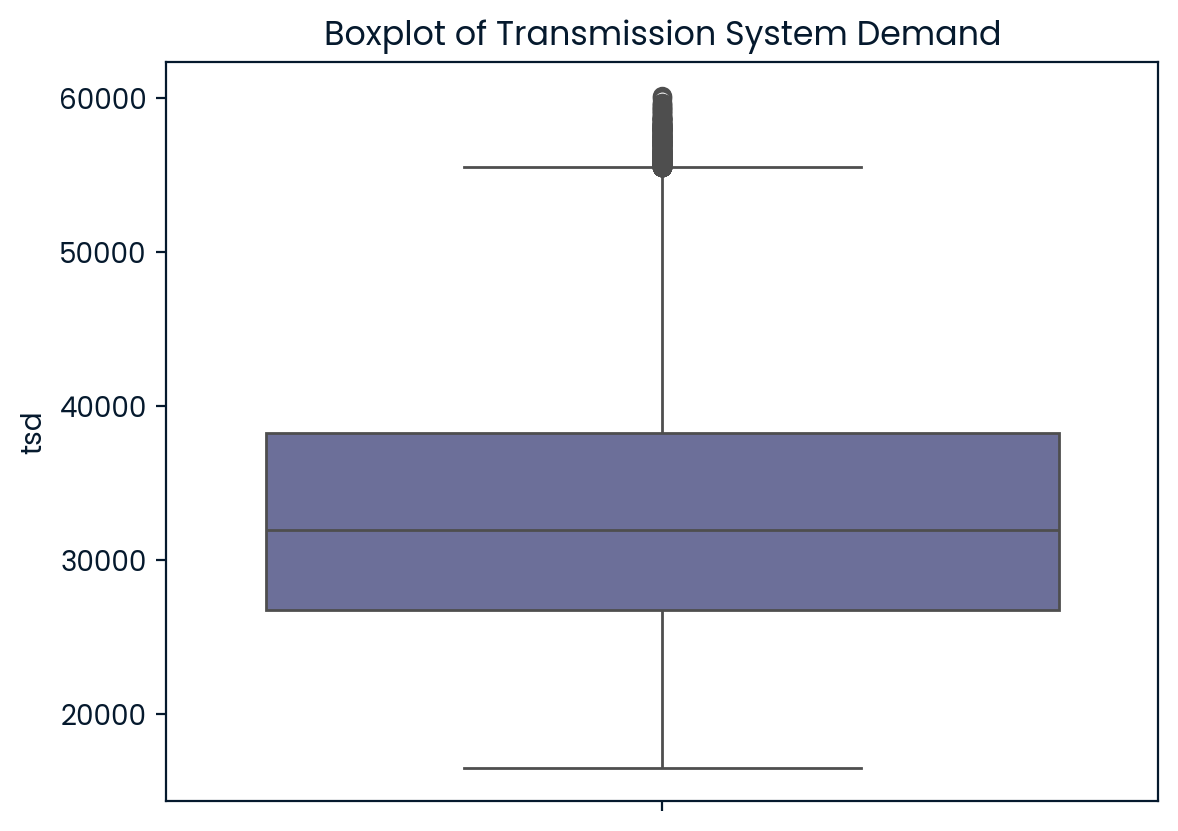

In [82]:
sns.boxplot(data=energy_sub['tsd'])
plt.title('Boxplot of Transmission System Demand')

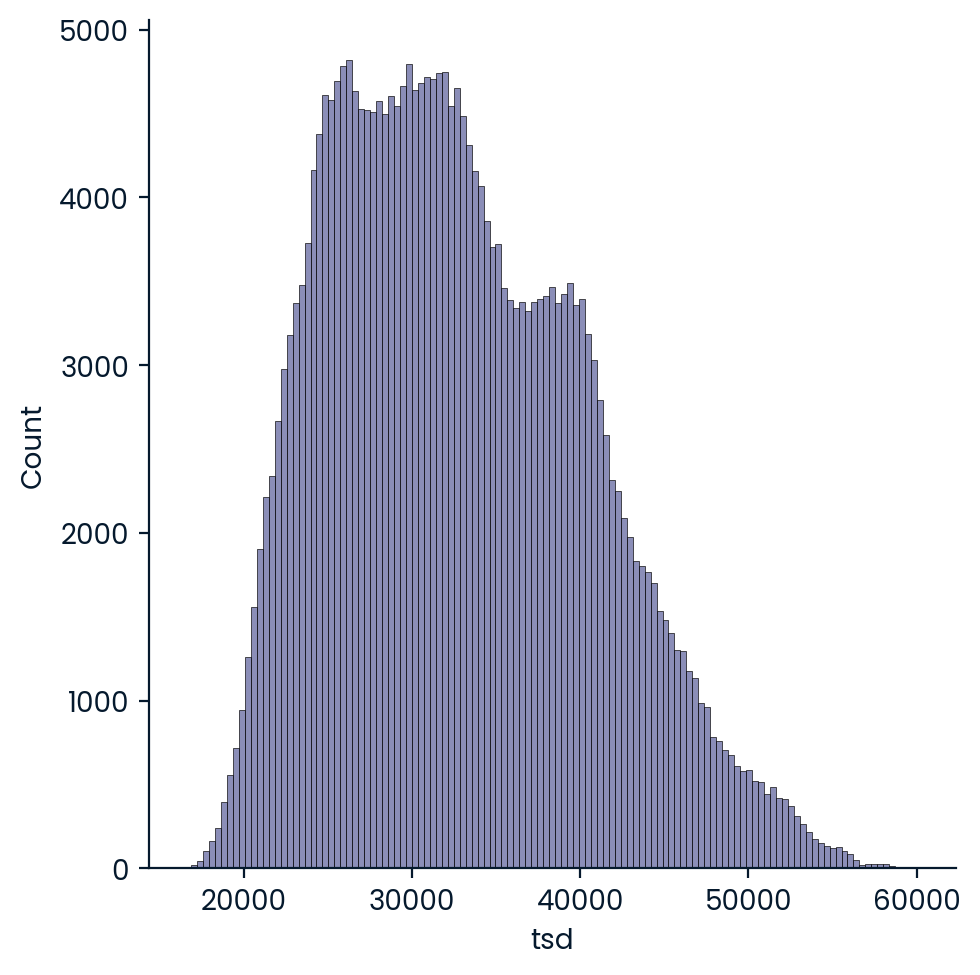

In [83]:
#Distribution of Transmission System Demand 
sns.displot(energy_sub['tsd'])

Text(0.5, 1.0, 'Electricity Demand vs Year')

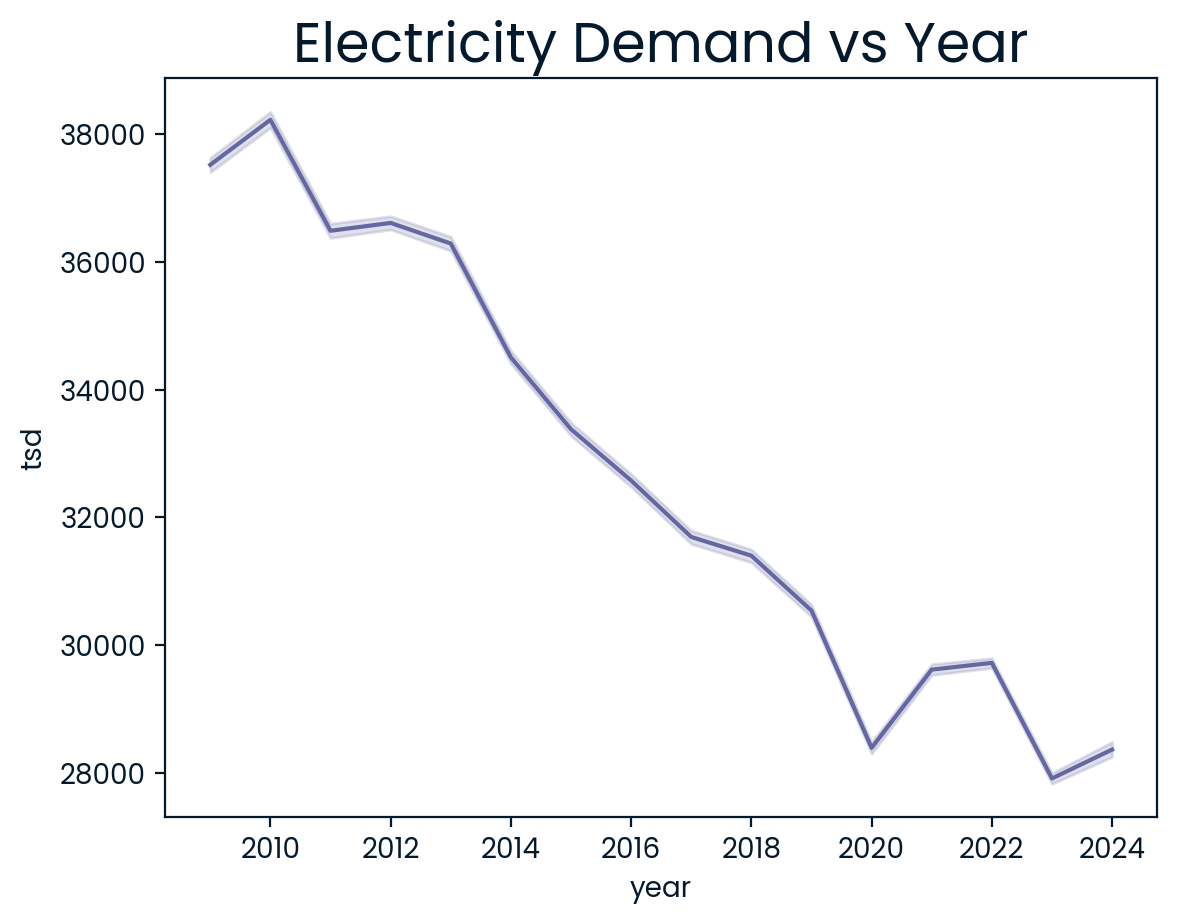

In [84]:
#yearly consumption visualization
sns.lineplot(x=energy_sub['year'],y=energy_sub['tsd'],data=energy_sub)
plt.title('Electricity Demand vs Year', fontsize=20)

Text(0.5, 1.0, 'Electricity Demand vs Months')

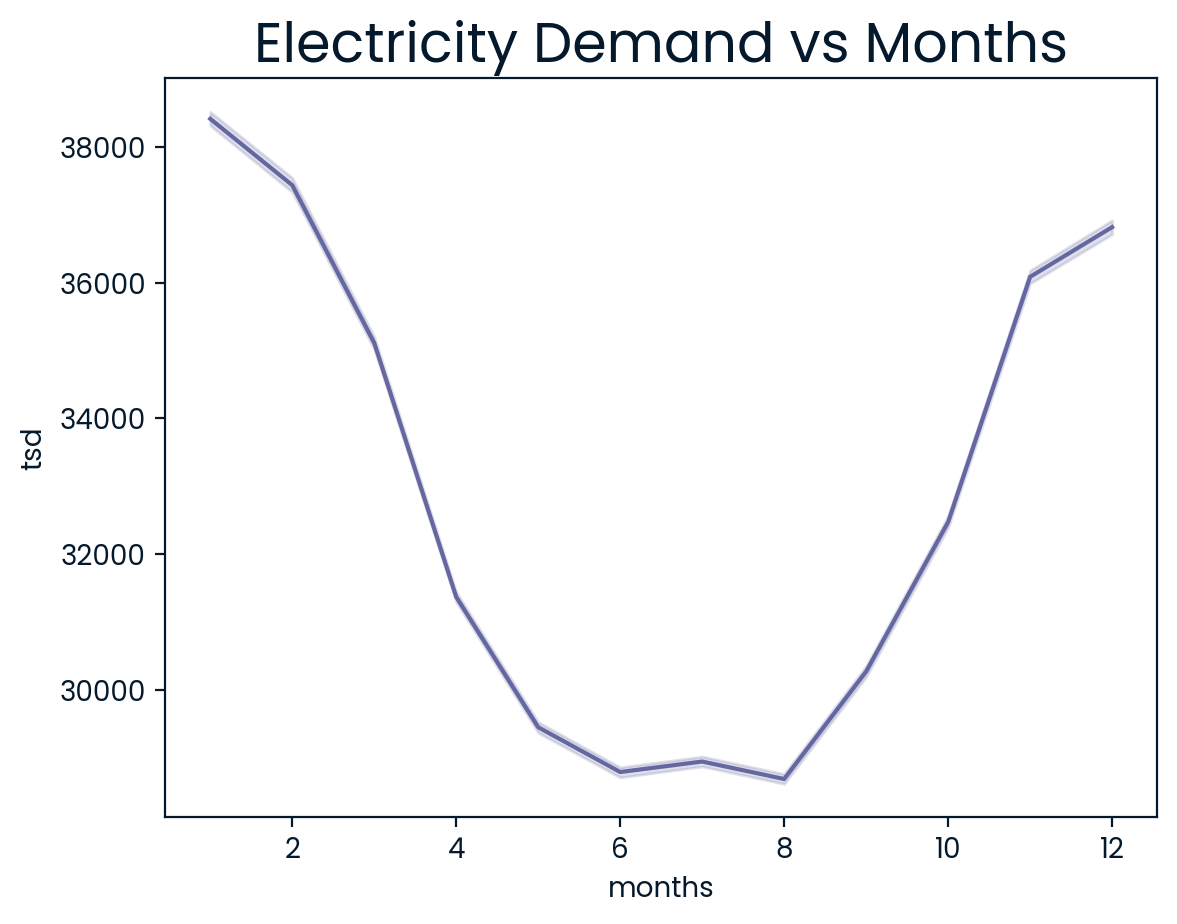

In [85]:
#Monthly consumption visualization
sns.lineplot(x=energy_sub['months'],y=energy_sub['tsd'],data=energy_sub)
plt.title('Electricity Demand vs Months',fontsize=20)

Text(0.5, 1.0, 'Electricity Demand vs Holiday')

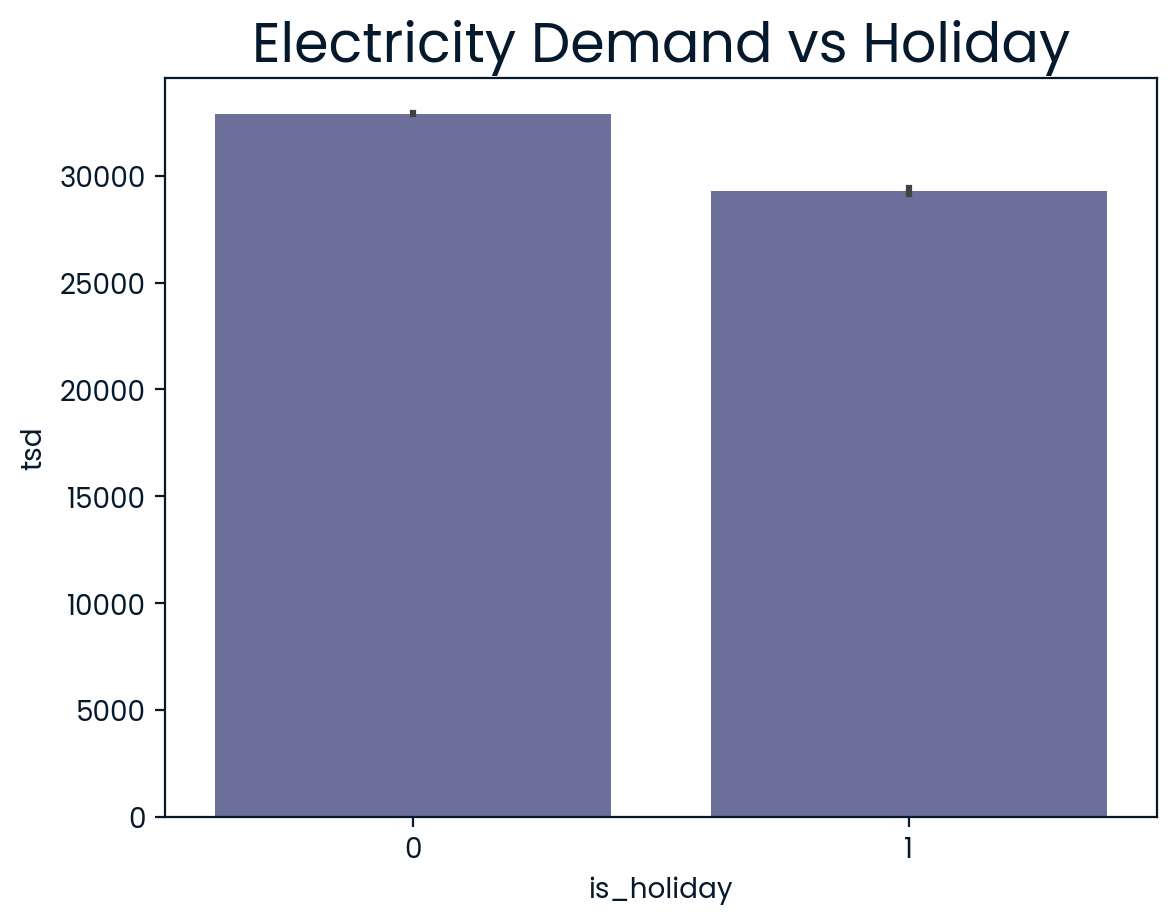

In [86]:
# Energy consumption during Holidays visualization
sns.barplot(x='is_holiday', y='tsd', data=energy_sub)
plt.title('Electricity Demand vs Holiday', fontsize=20)

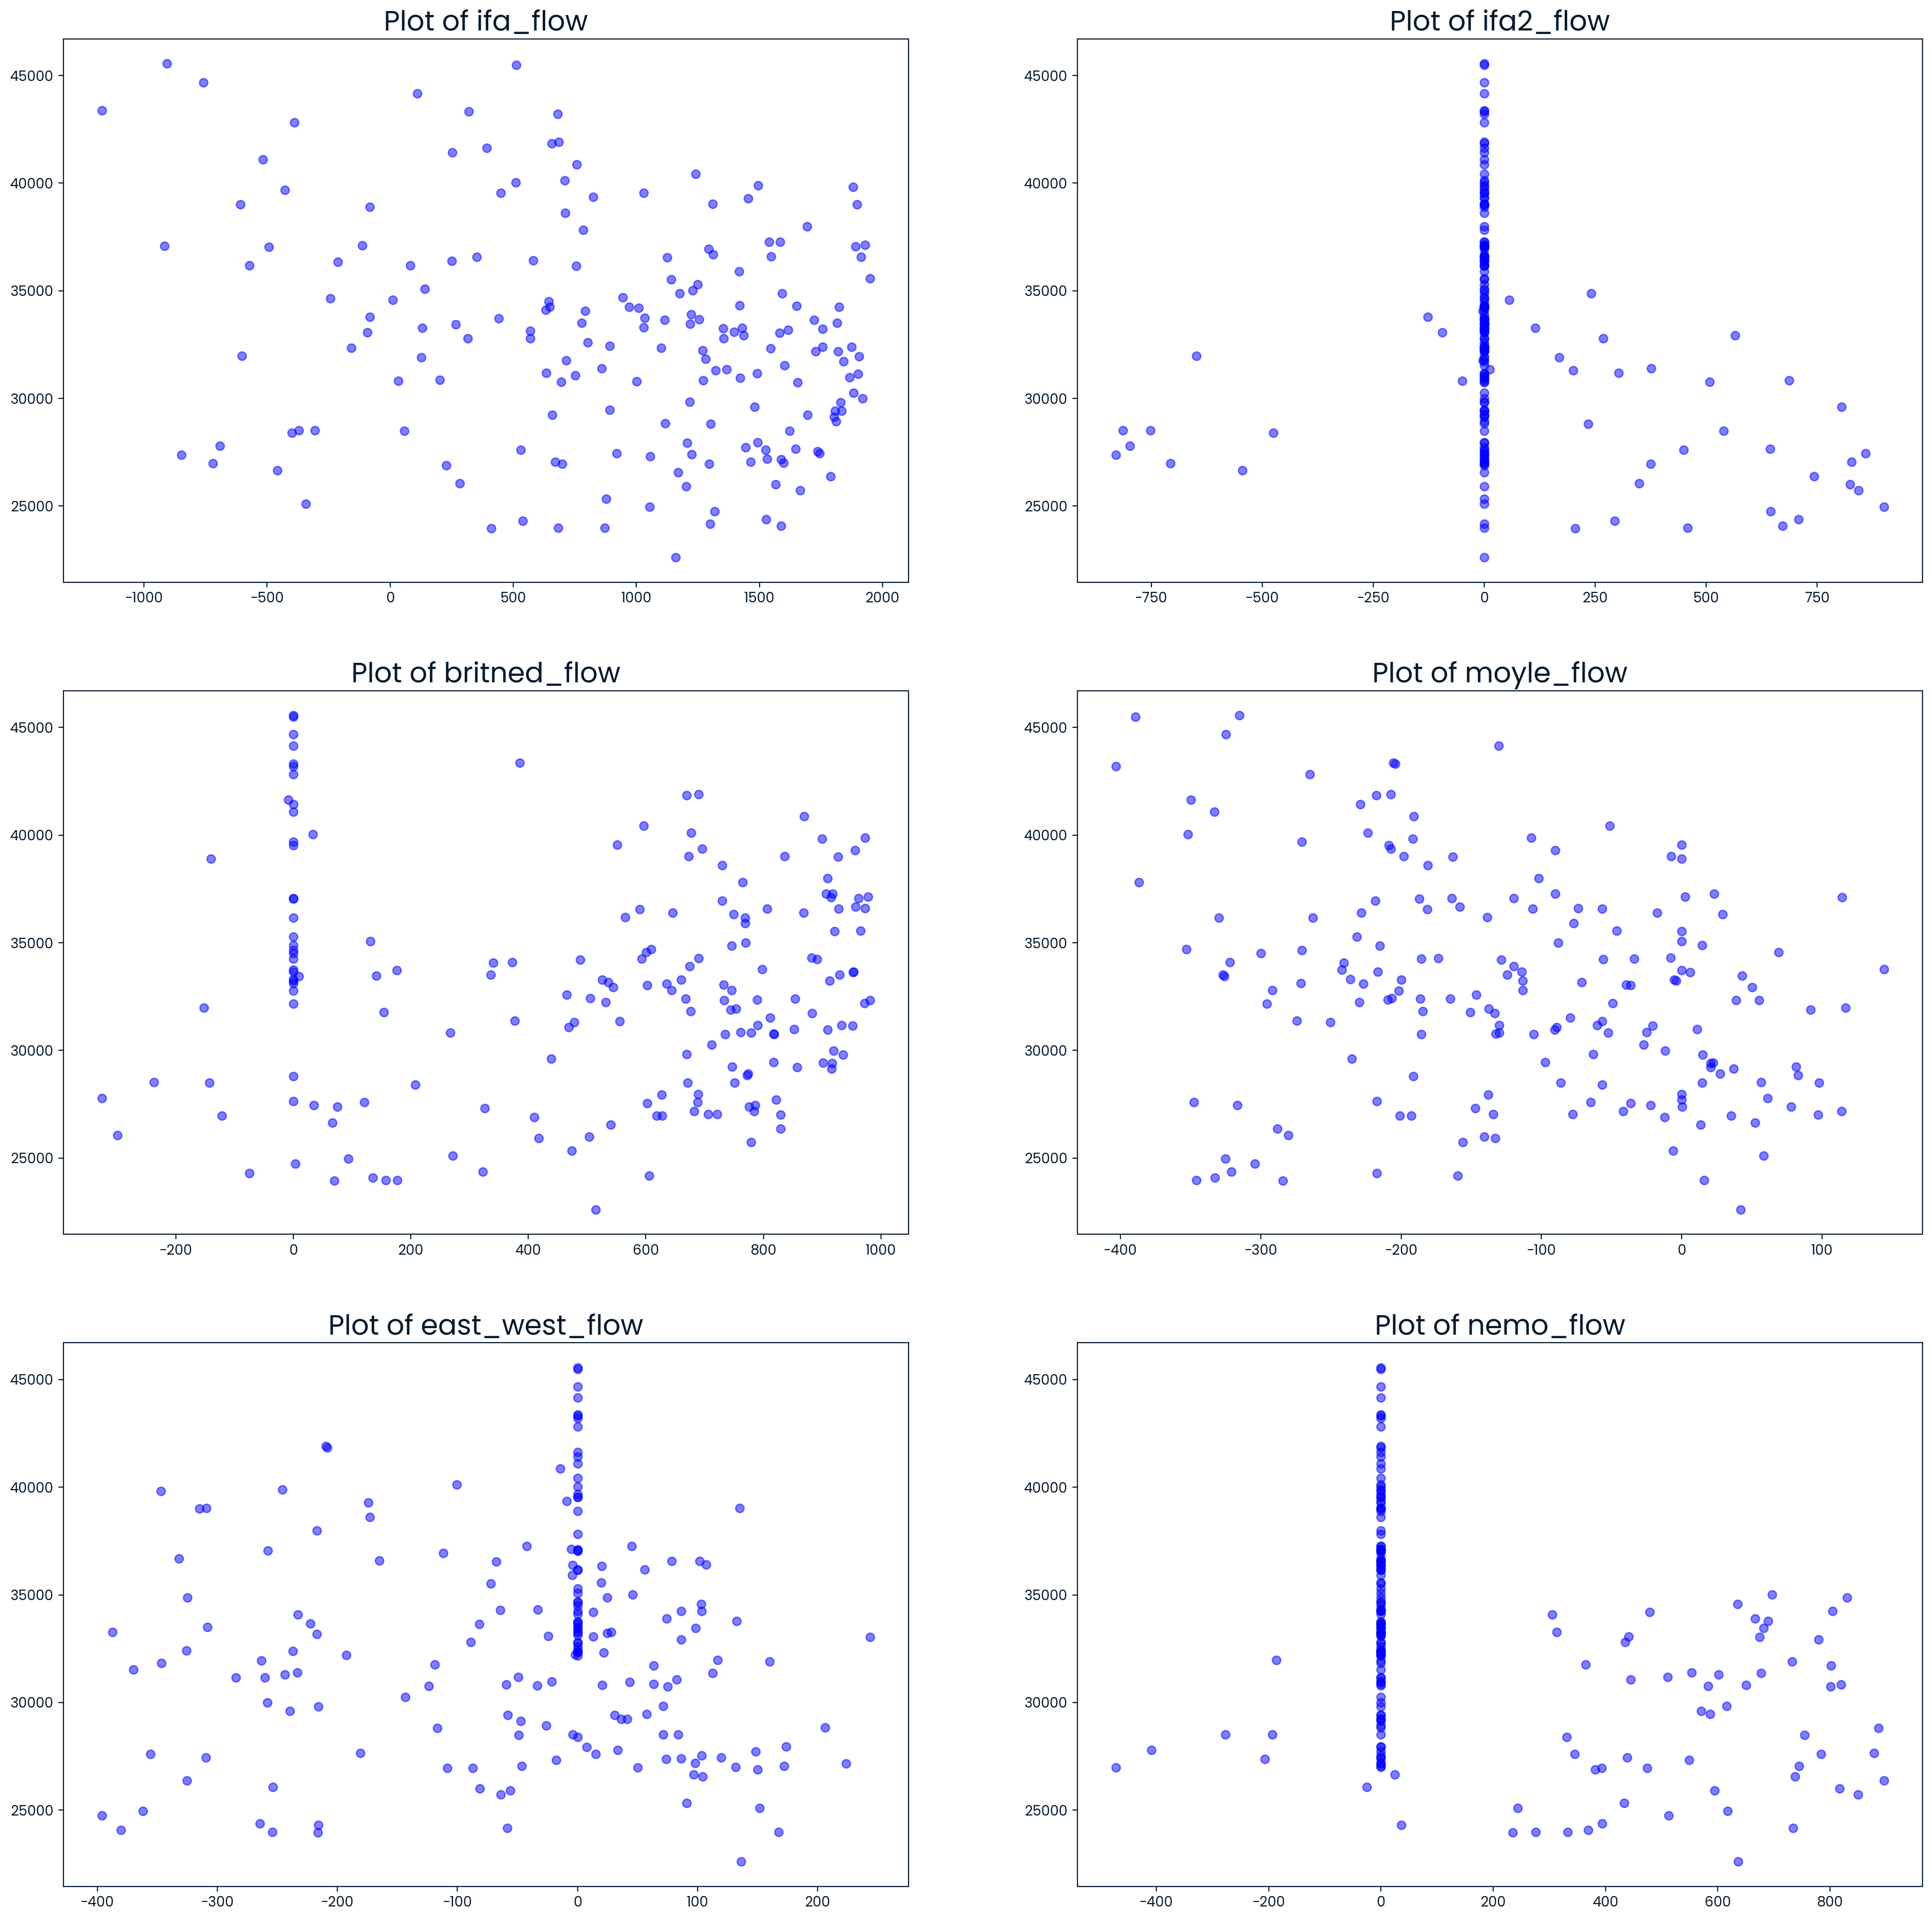

In [87]:
# relationship between interconnectors and Transmission System Demand
import matplotlib.pyplot as plt

interconnector_flows = ['ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow']

fig, ax = plt.subplots(ncols=2, nrows=3)
fig.set_figheight(24)
fig.set_figwidth(24)
for i, group in enumerate(interconnector_flows):
    ax[int(i/2), int(i%2)].scatter(x=avg_month[group], y=avg_month['tsd'], c='blue', alpha=0.5)
    ax[int(i/2), int(i%2)].set_title(f'Plot of {group}',fontsize=20)
plt.show()

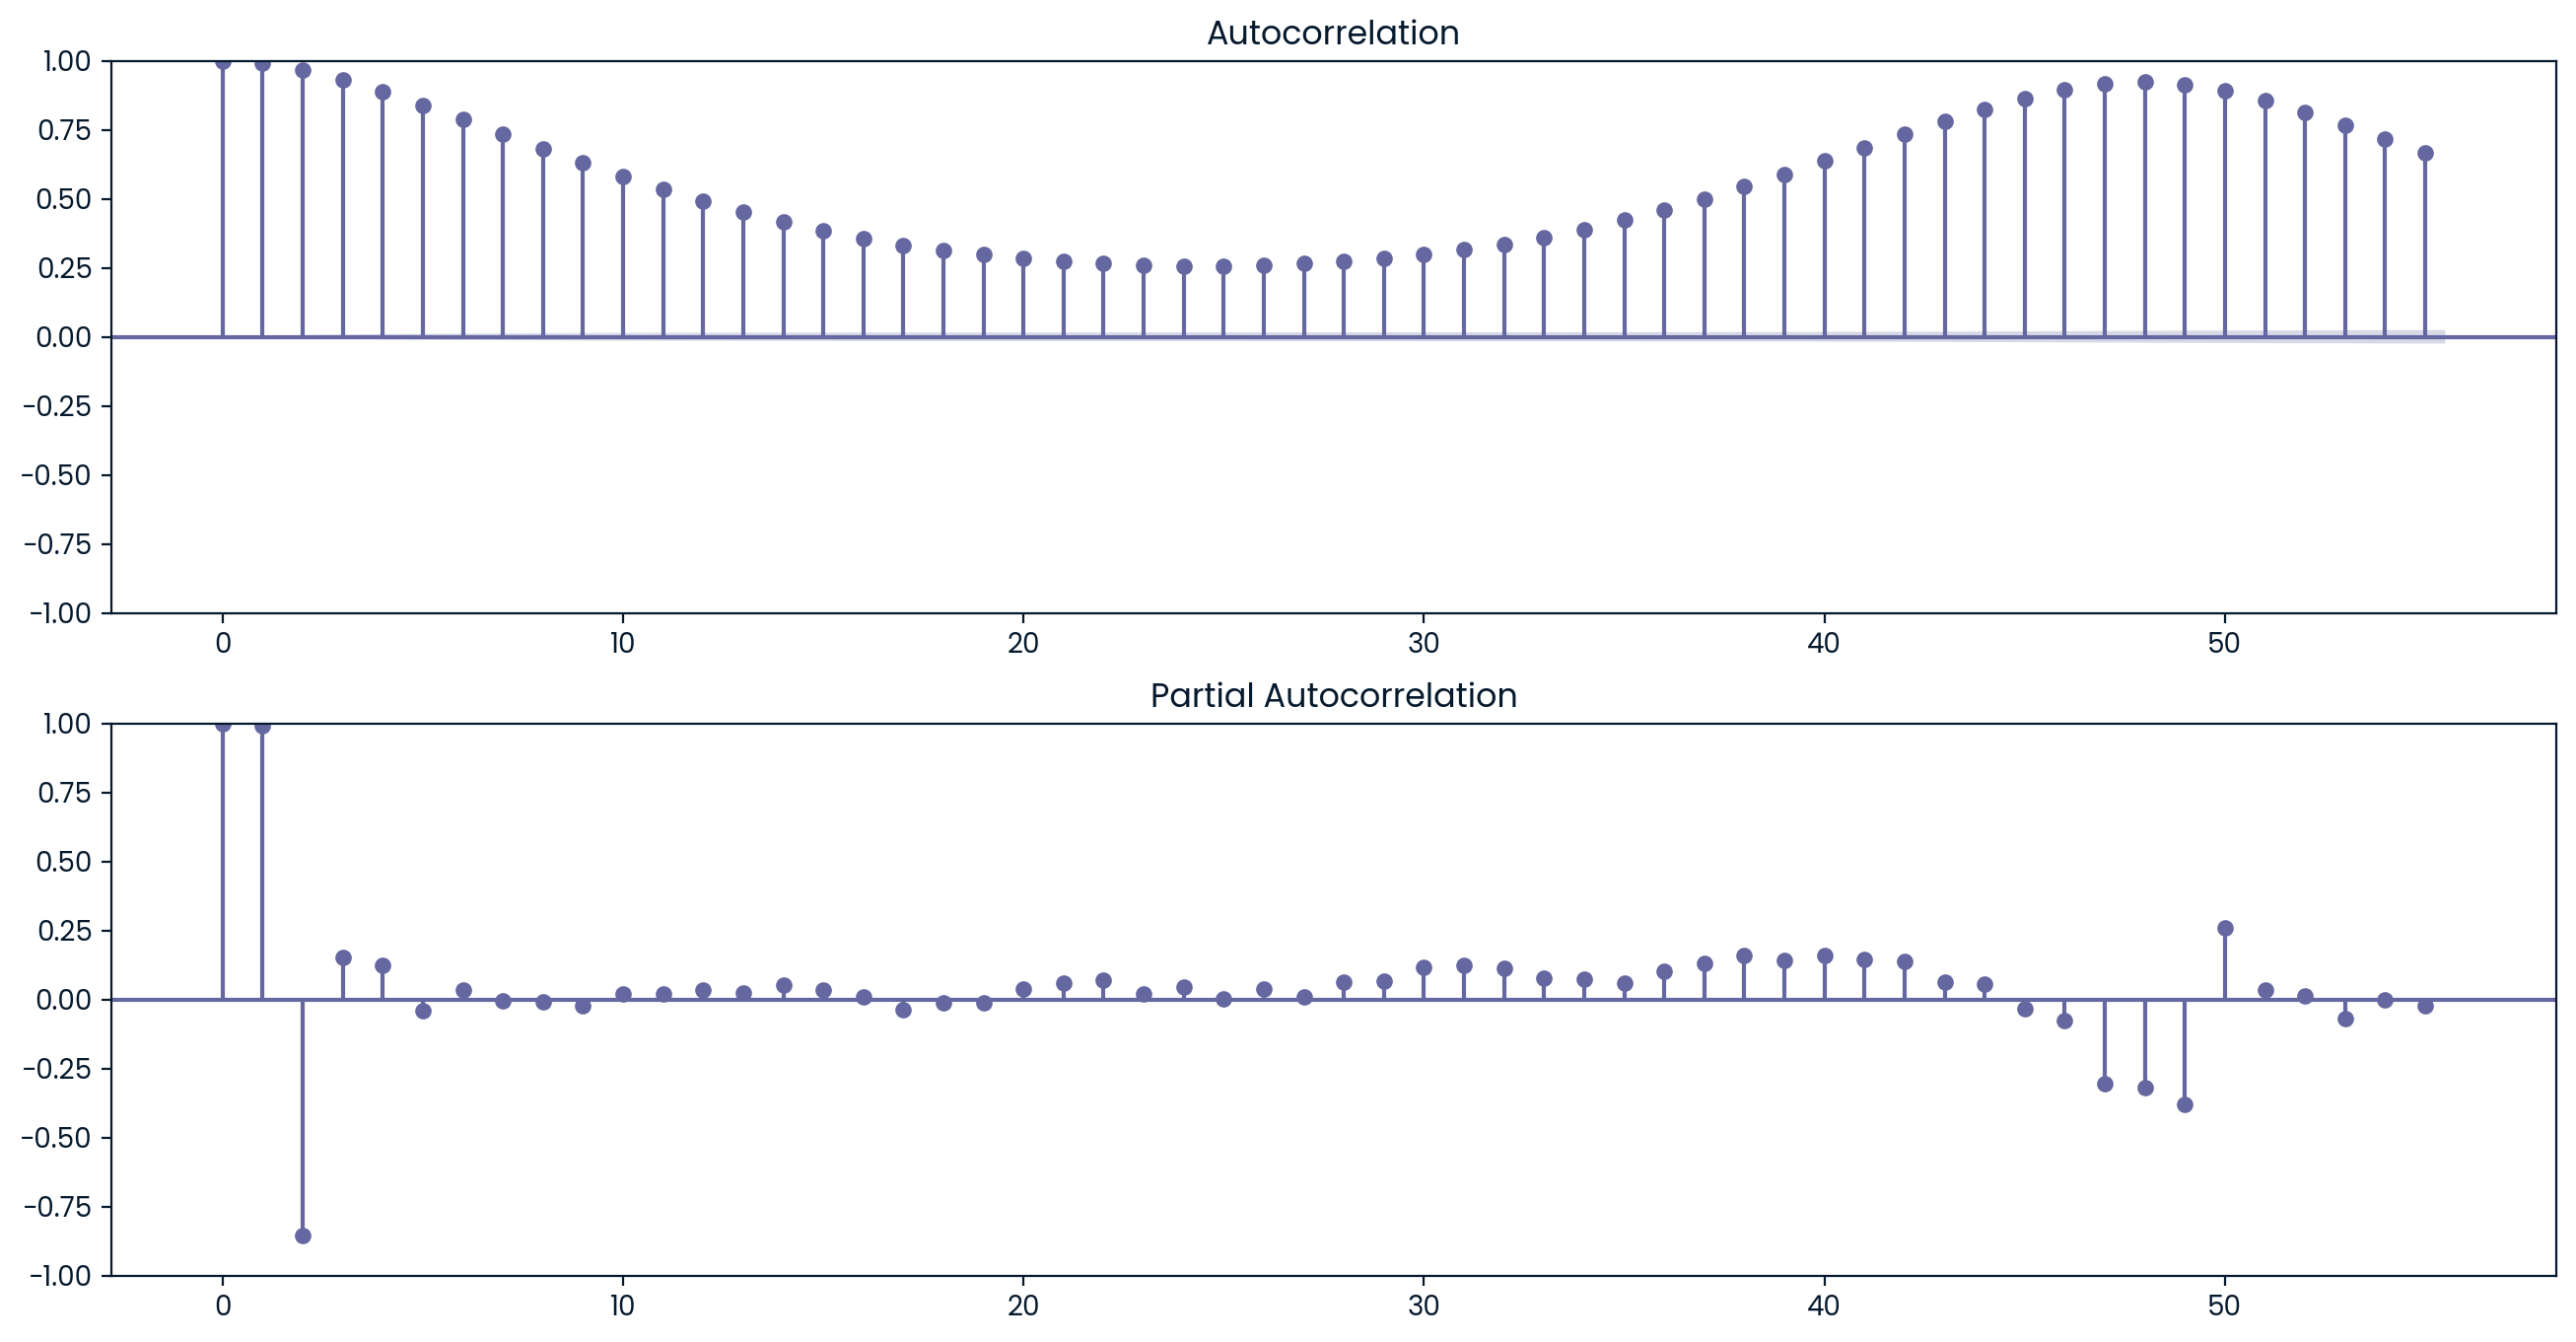

In [88]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 2*4))
plot_acf(energy_sub['tsd'], ax=ax[0]);
plot_pacf(energy_sub['tsd'], ax=ax[1], method='ols');

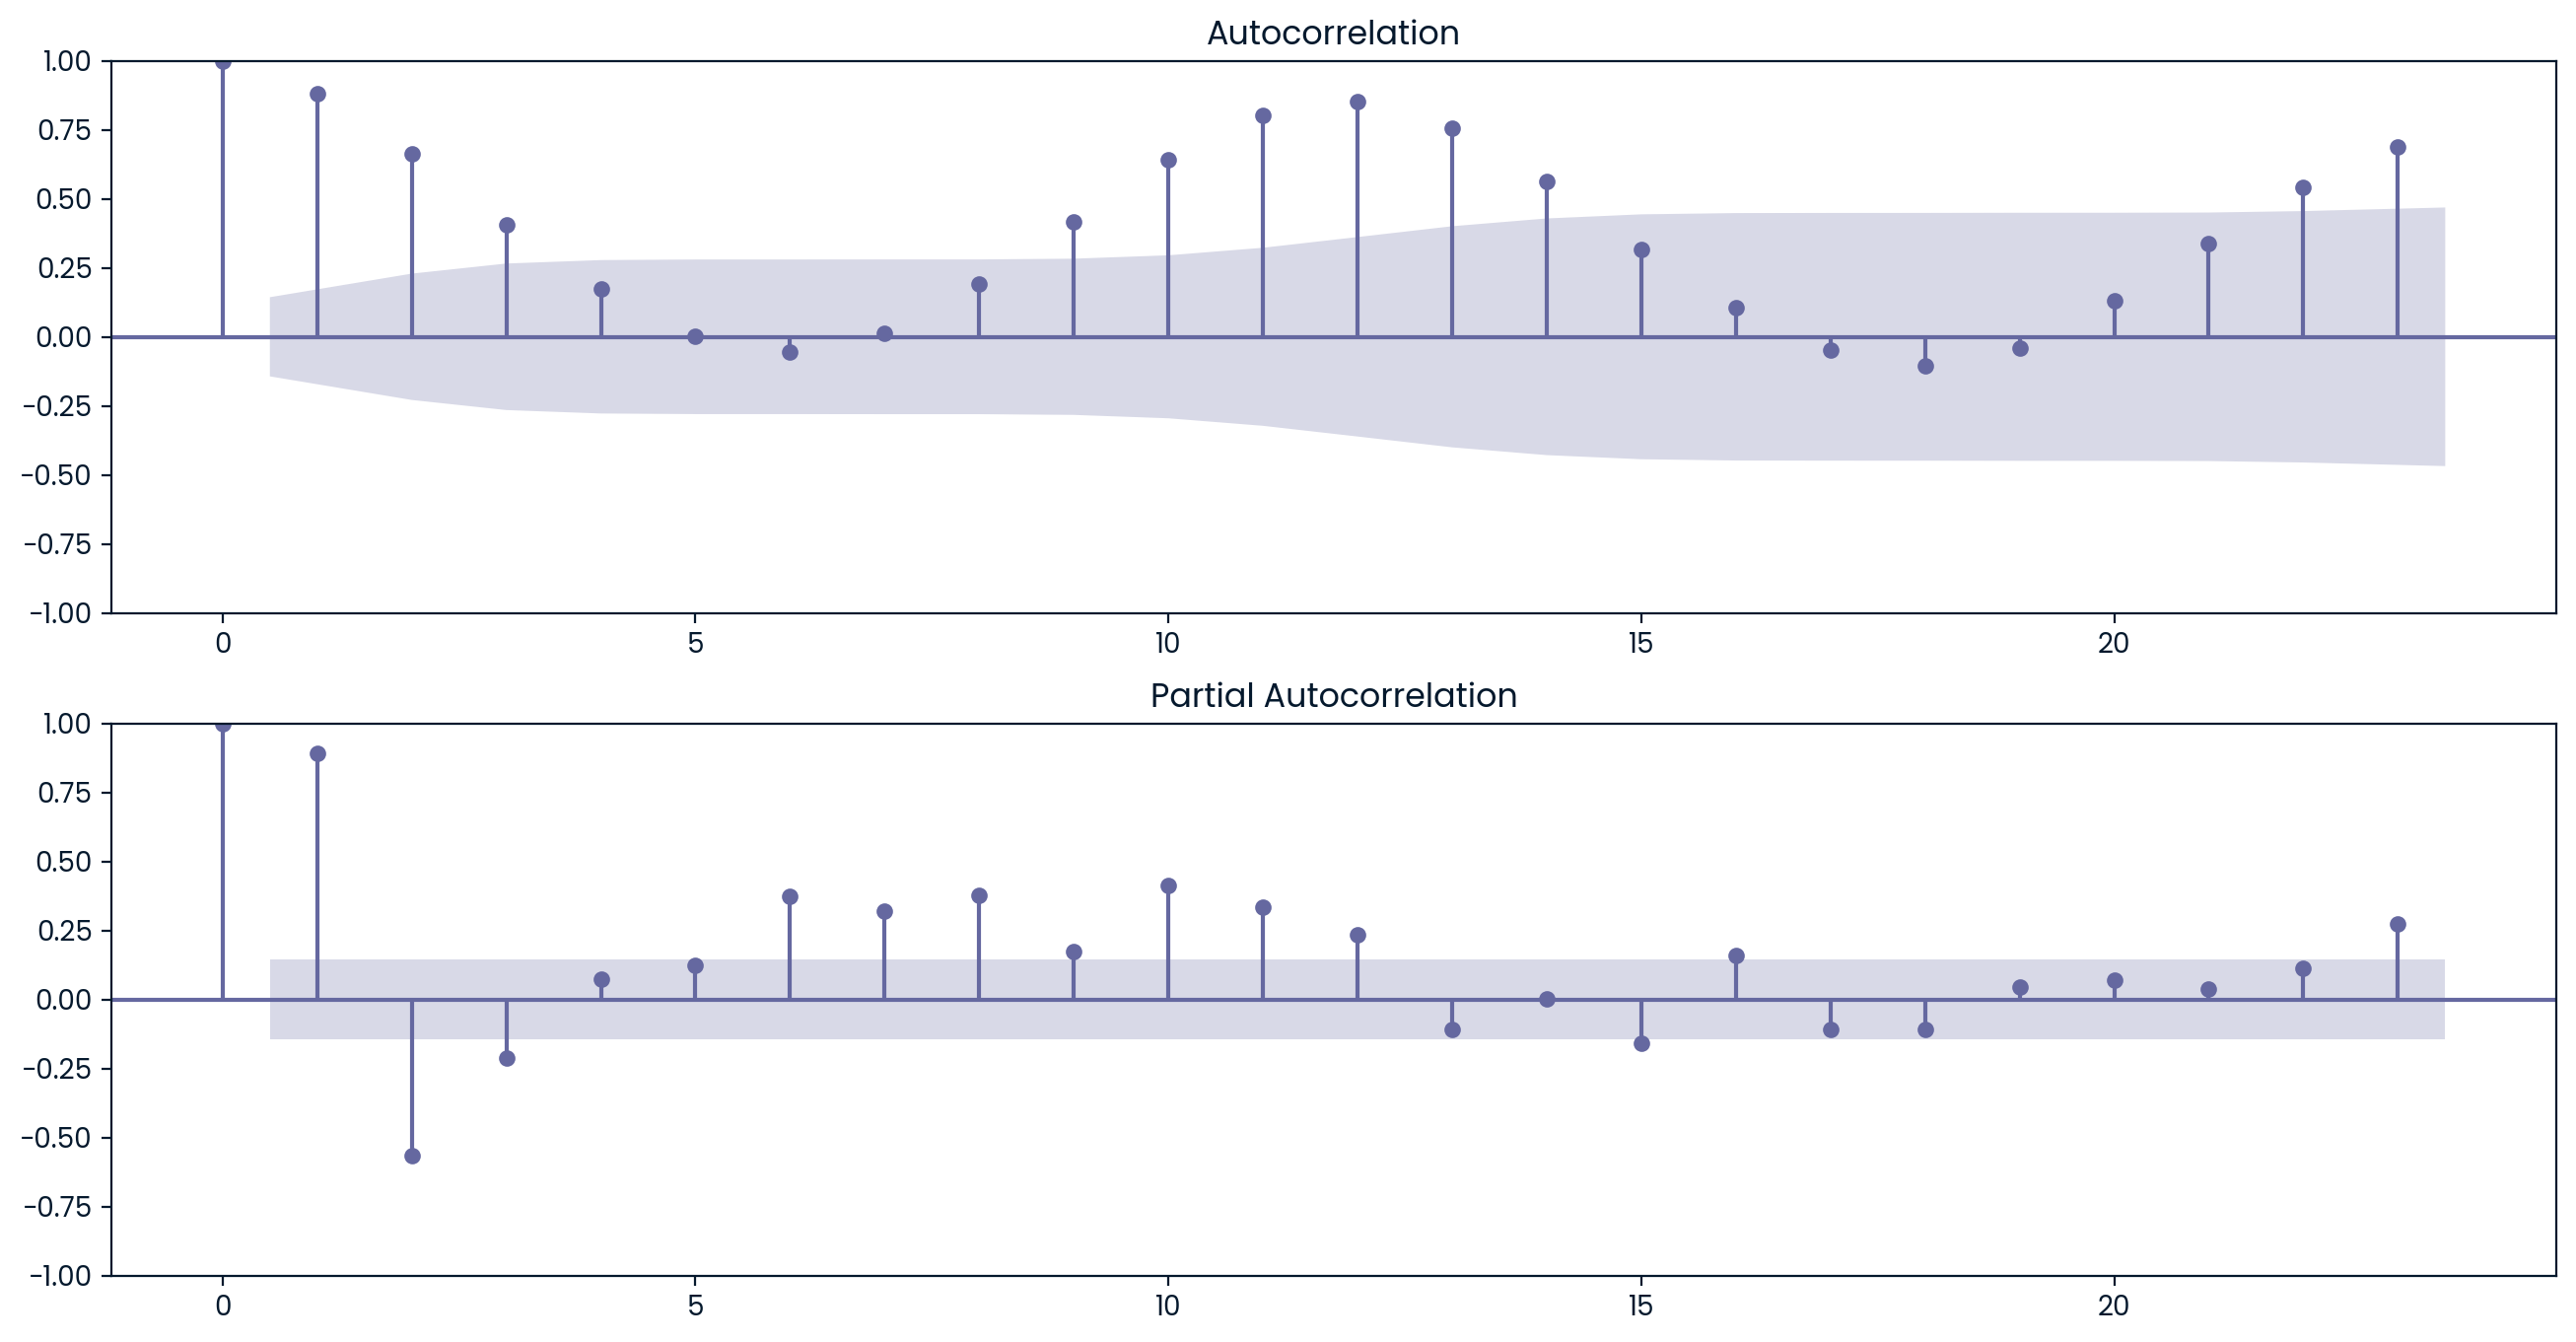

In [89]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 2*4))
plot_acf(avg_month['tsd'], ax=ax[0]);
plot_pacf(avg_month['tsd'], ax=ax[1], method='ols');

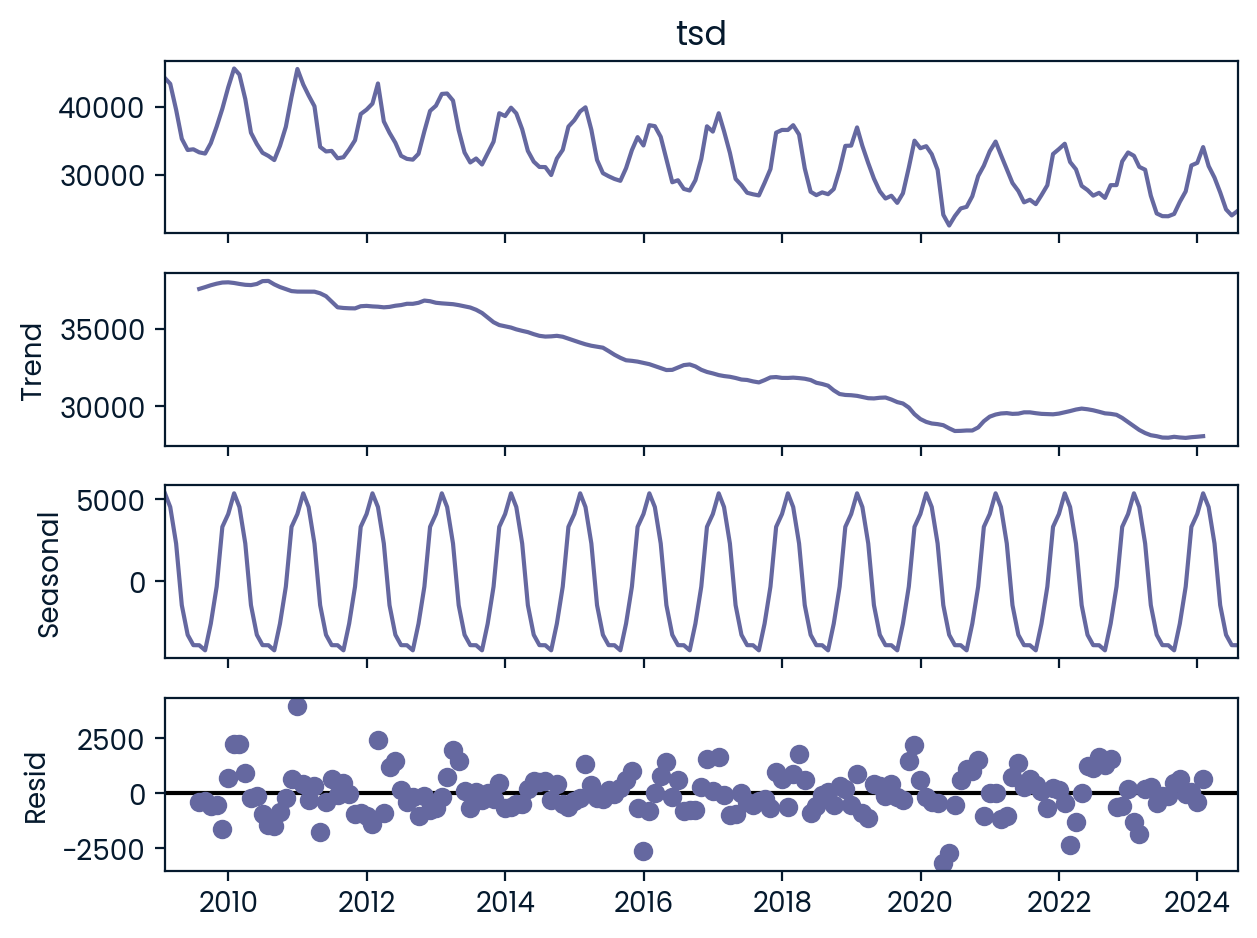

In [90]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Adjust the period to match the available data
period = 12  # Assuming monthly data with a yearly seasonality

seasonal_decompose(avg_month["tsd"].dropna(), period=period).plot()
plt.show()

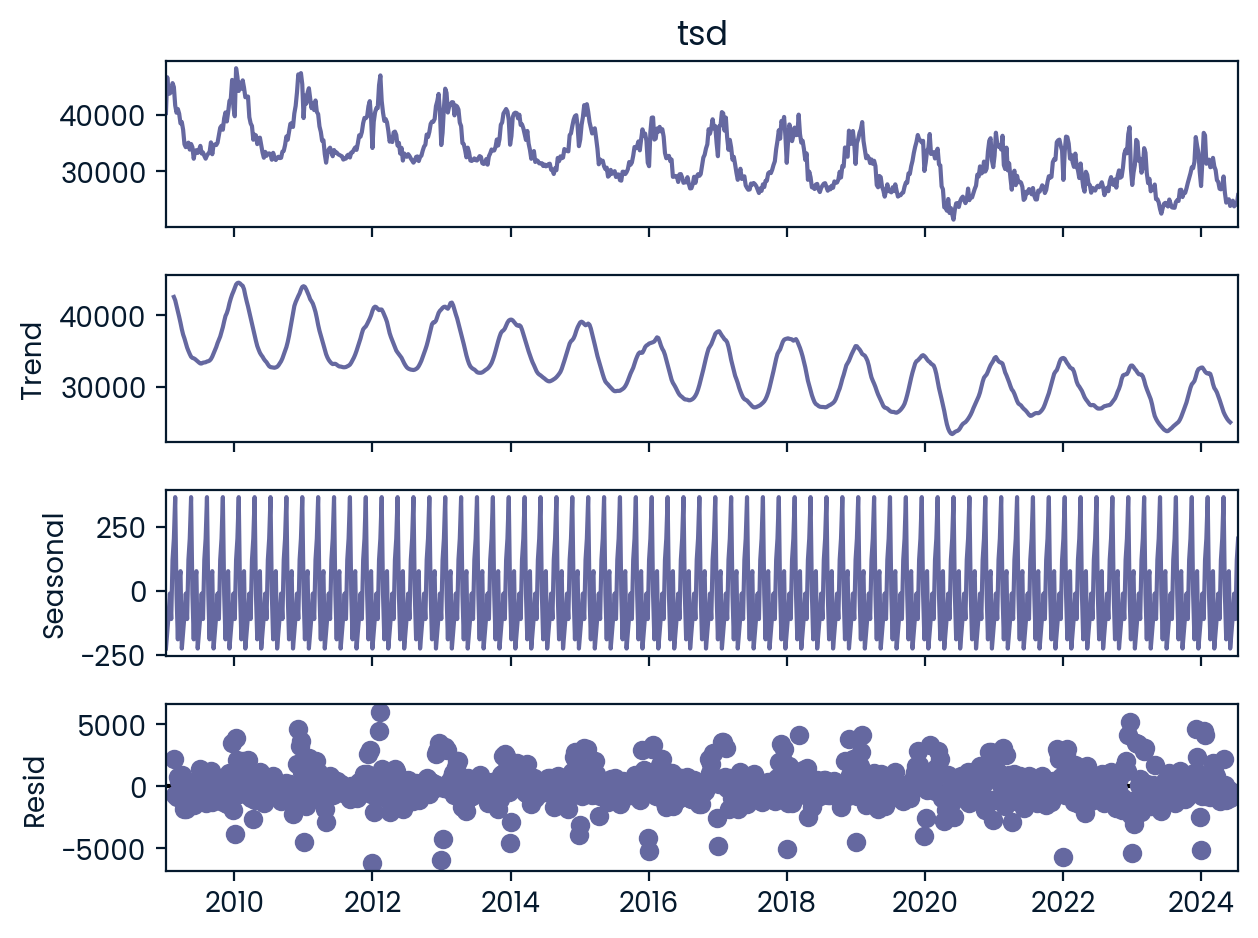

In [91]:
# Adjust the period to match the available data
period = 12  # Assuming monthly data with a yearly seasonality

seasonal_decompose(weekly["tsd"].dropna(), period=period).plot()
plt.show()

In [92]:
#Fit Auto ARIMA to get the best ARIMA model.
#Using Monthly Demand

model = auto_arima(avg_month['tsd'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=None,max_d=2,max_D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
model.aic()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3352.243, Time=2.93 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3402.850, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3340.724, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3352.731, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3401.253, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3390.182, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3335.423, Time=1.57 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=9.60 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3282.671, Time=3.00 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3351.197, Time=0.59 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=12.61 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3346.281, Time=2.09 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=12.89 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.52 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   

3281.680339616793

In [93]:
import statsmodels.api as sm
#Fit ARIMA model
model = sm.tsa.ARIMA(avg_month['tsd'], order=(0,1,1), seasonal_order=(1,0,1,12))
output = model.fit()

In [94]:
predictions = output.fittedvalues

output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                              tsd   No. Observations:                  187
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1638.511
Date:                          Sat, 17 Aug 2024   AIC                           3285.022
Time:                                  07:57:58   BIC                           3297.925
Sample:                              01-31-2009   HQIC                          3290.251
                                   - 07-31-2024                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0584      0.025      2.298      0.022       0.009       0.108
ar.S.L12       0.9676      0.021     46.126      0.000       0.926       1.009
ma.S.L12      -0.8774      0.044    -20.088      0.000      -0.963      -0.792
sigma2      2.264e+06   3.93e-09   5.76e+14      0.000    2.26e+06    2.26e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.77   Jarque-Bera (JB):                45.53
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.67e+30. Standard errors may be unstable.
"""

In [95]:
#forecasting future values
forecast_step = 12
forecasts = output.get_forecast(steps=forecast_step)
forecasts_mean = forecasts.predicted_mean
forecast_conf = forecasts.conf_int()

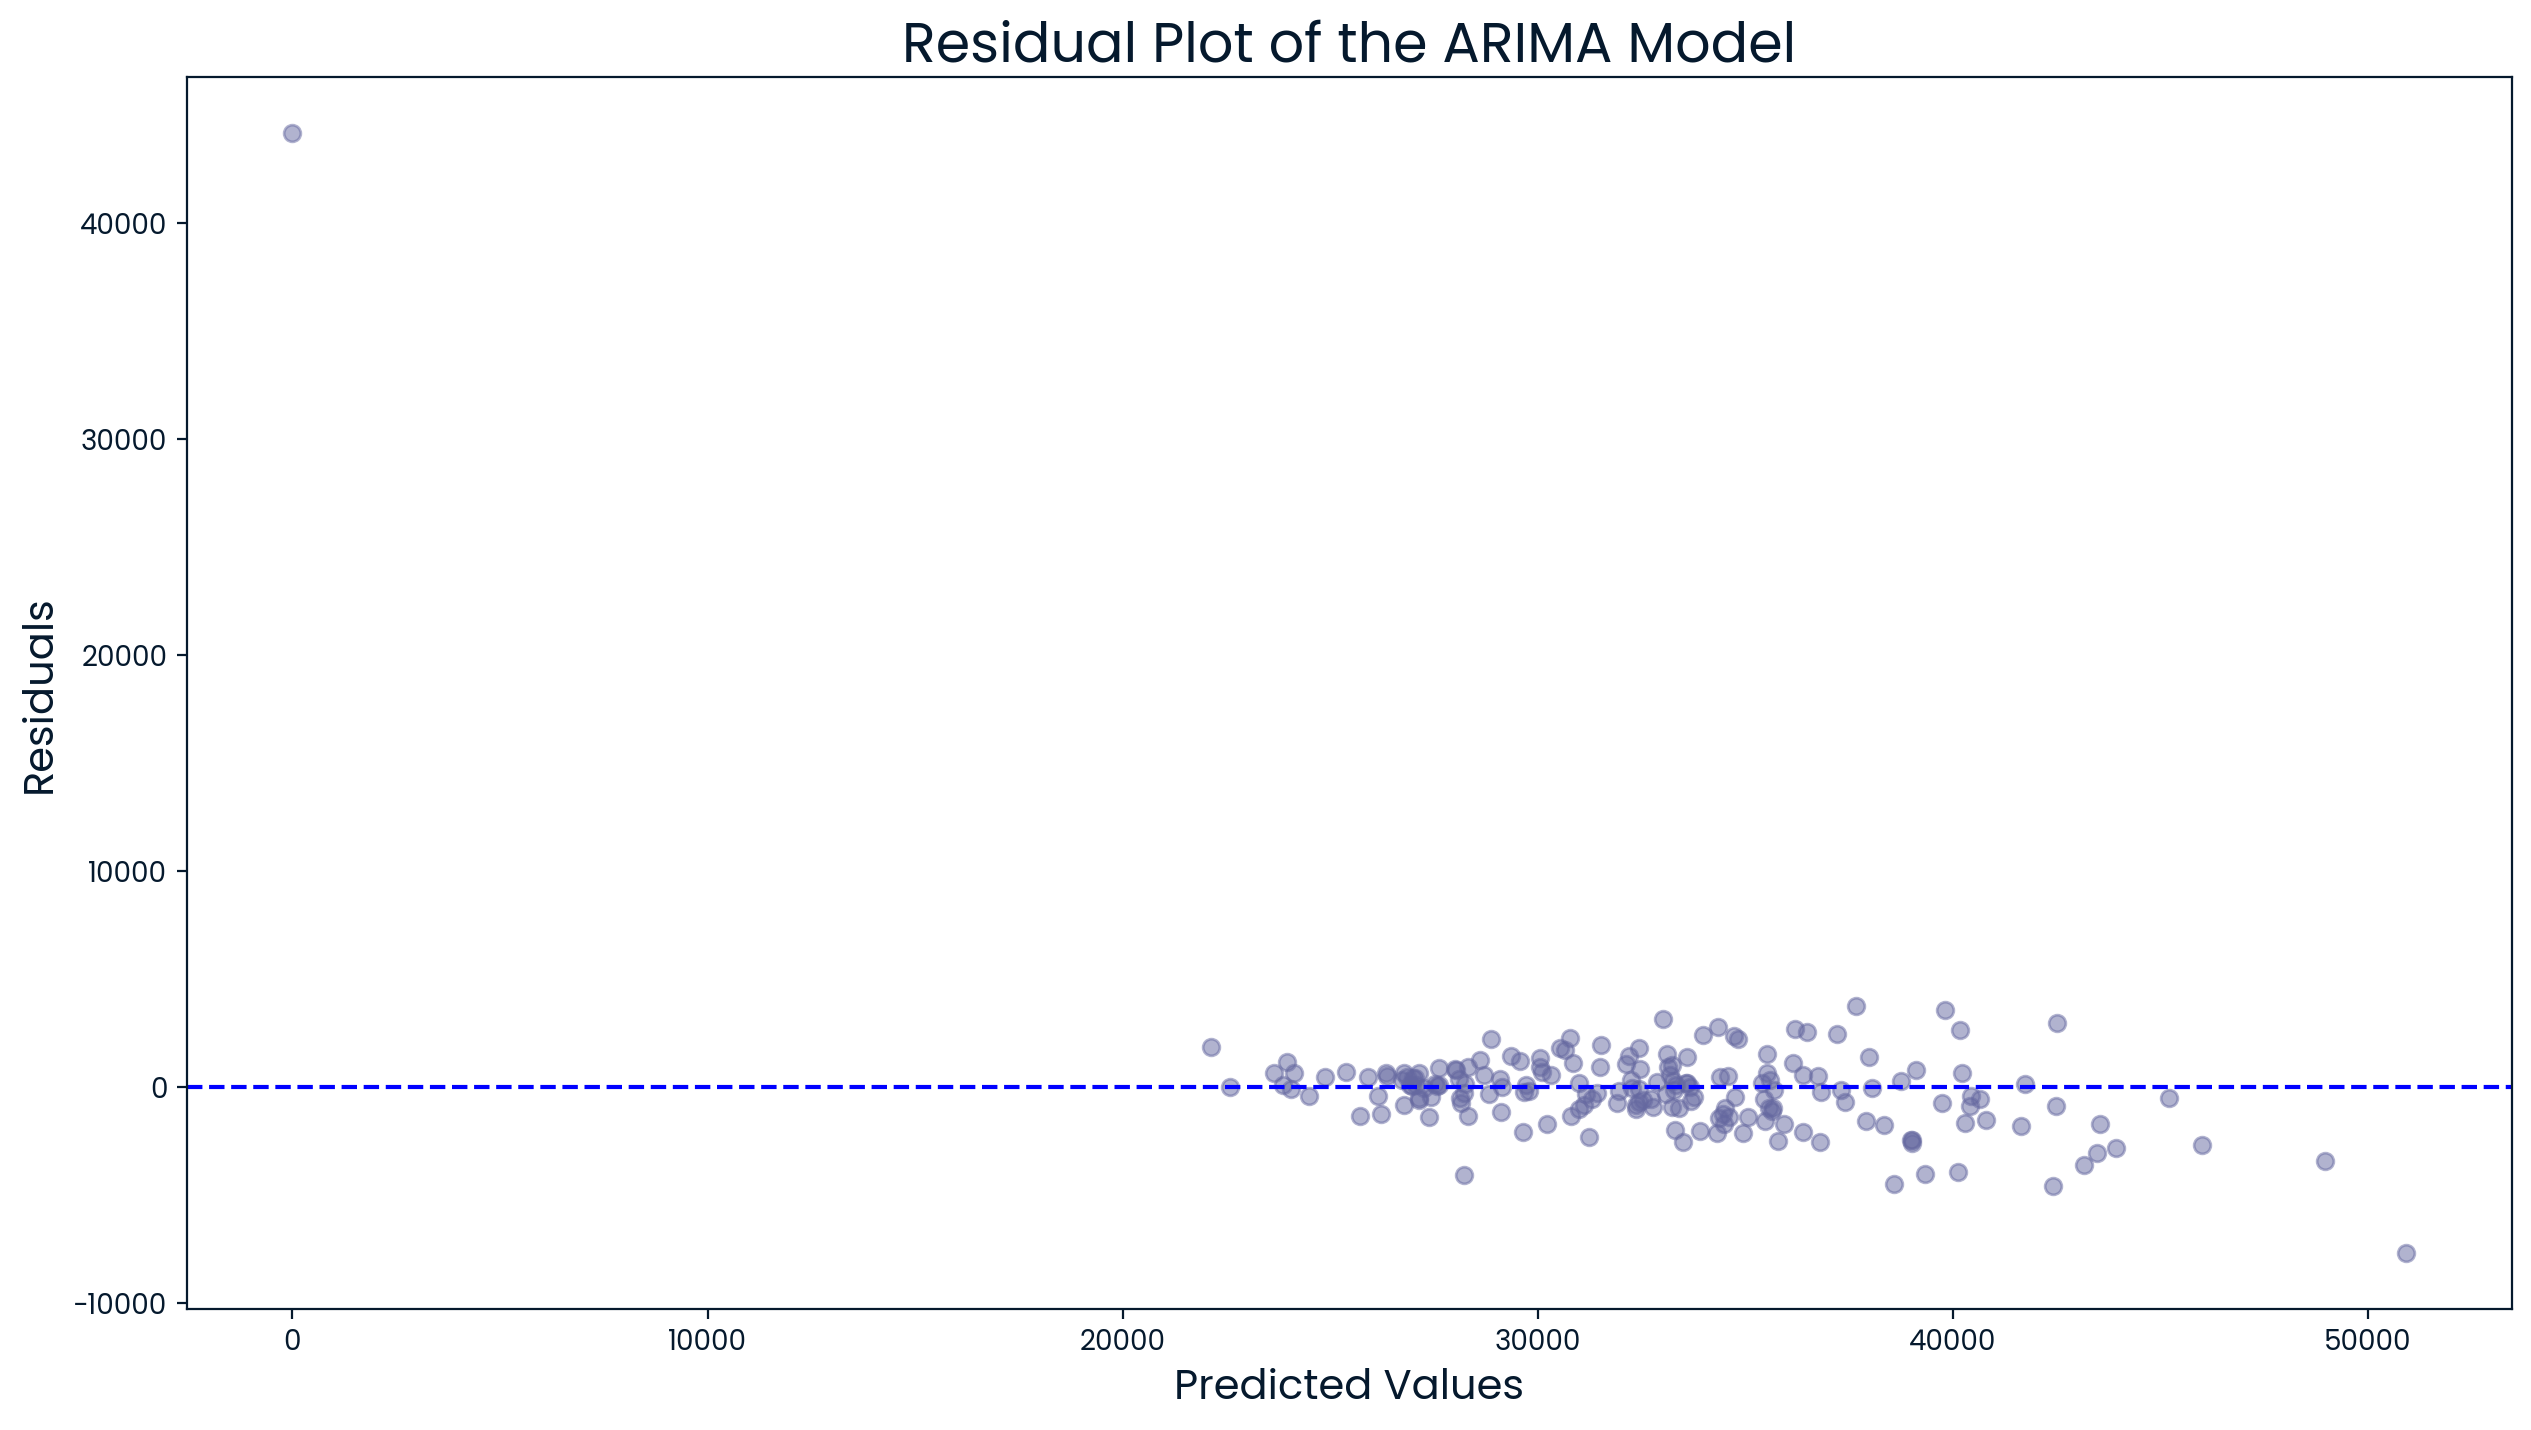

In [96]:
y = avg_month['tsd']
residuals = y - predictions

#residual plot
plt.figure(figsize=(15,8))
plt.scatter(predictions,residuals, alpha=0.5)
plt.axhline(0, color = 'blue', linestyle='--')
plt.xlabel('Predicted Values',fontsize=15)
plt.ylabel('Residuals',fontsize=15)
plt.title('Residual Plot of the ARIMA Model',fontsize=20)
plt.show()


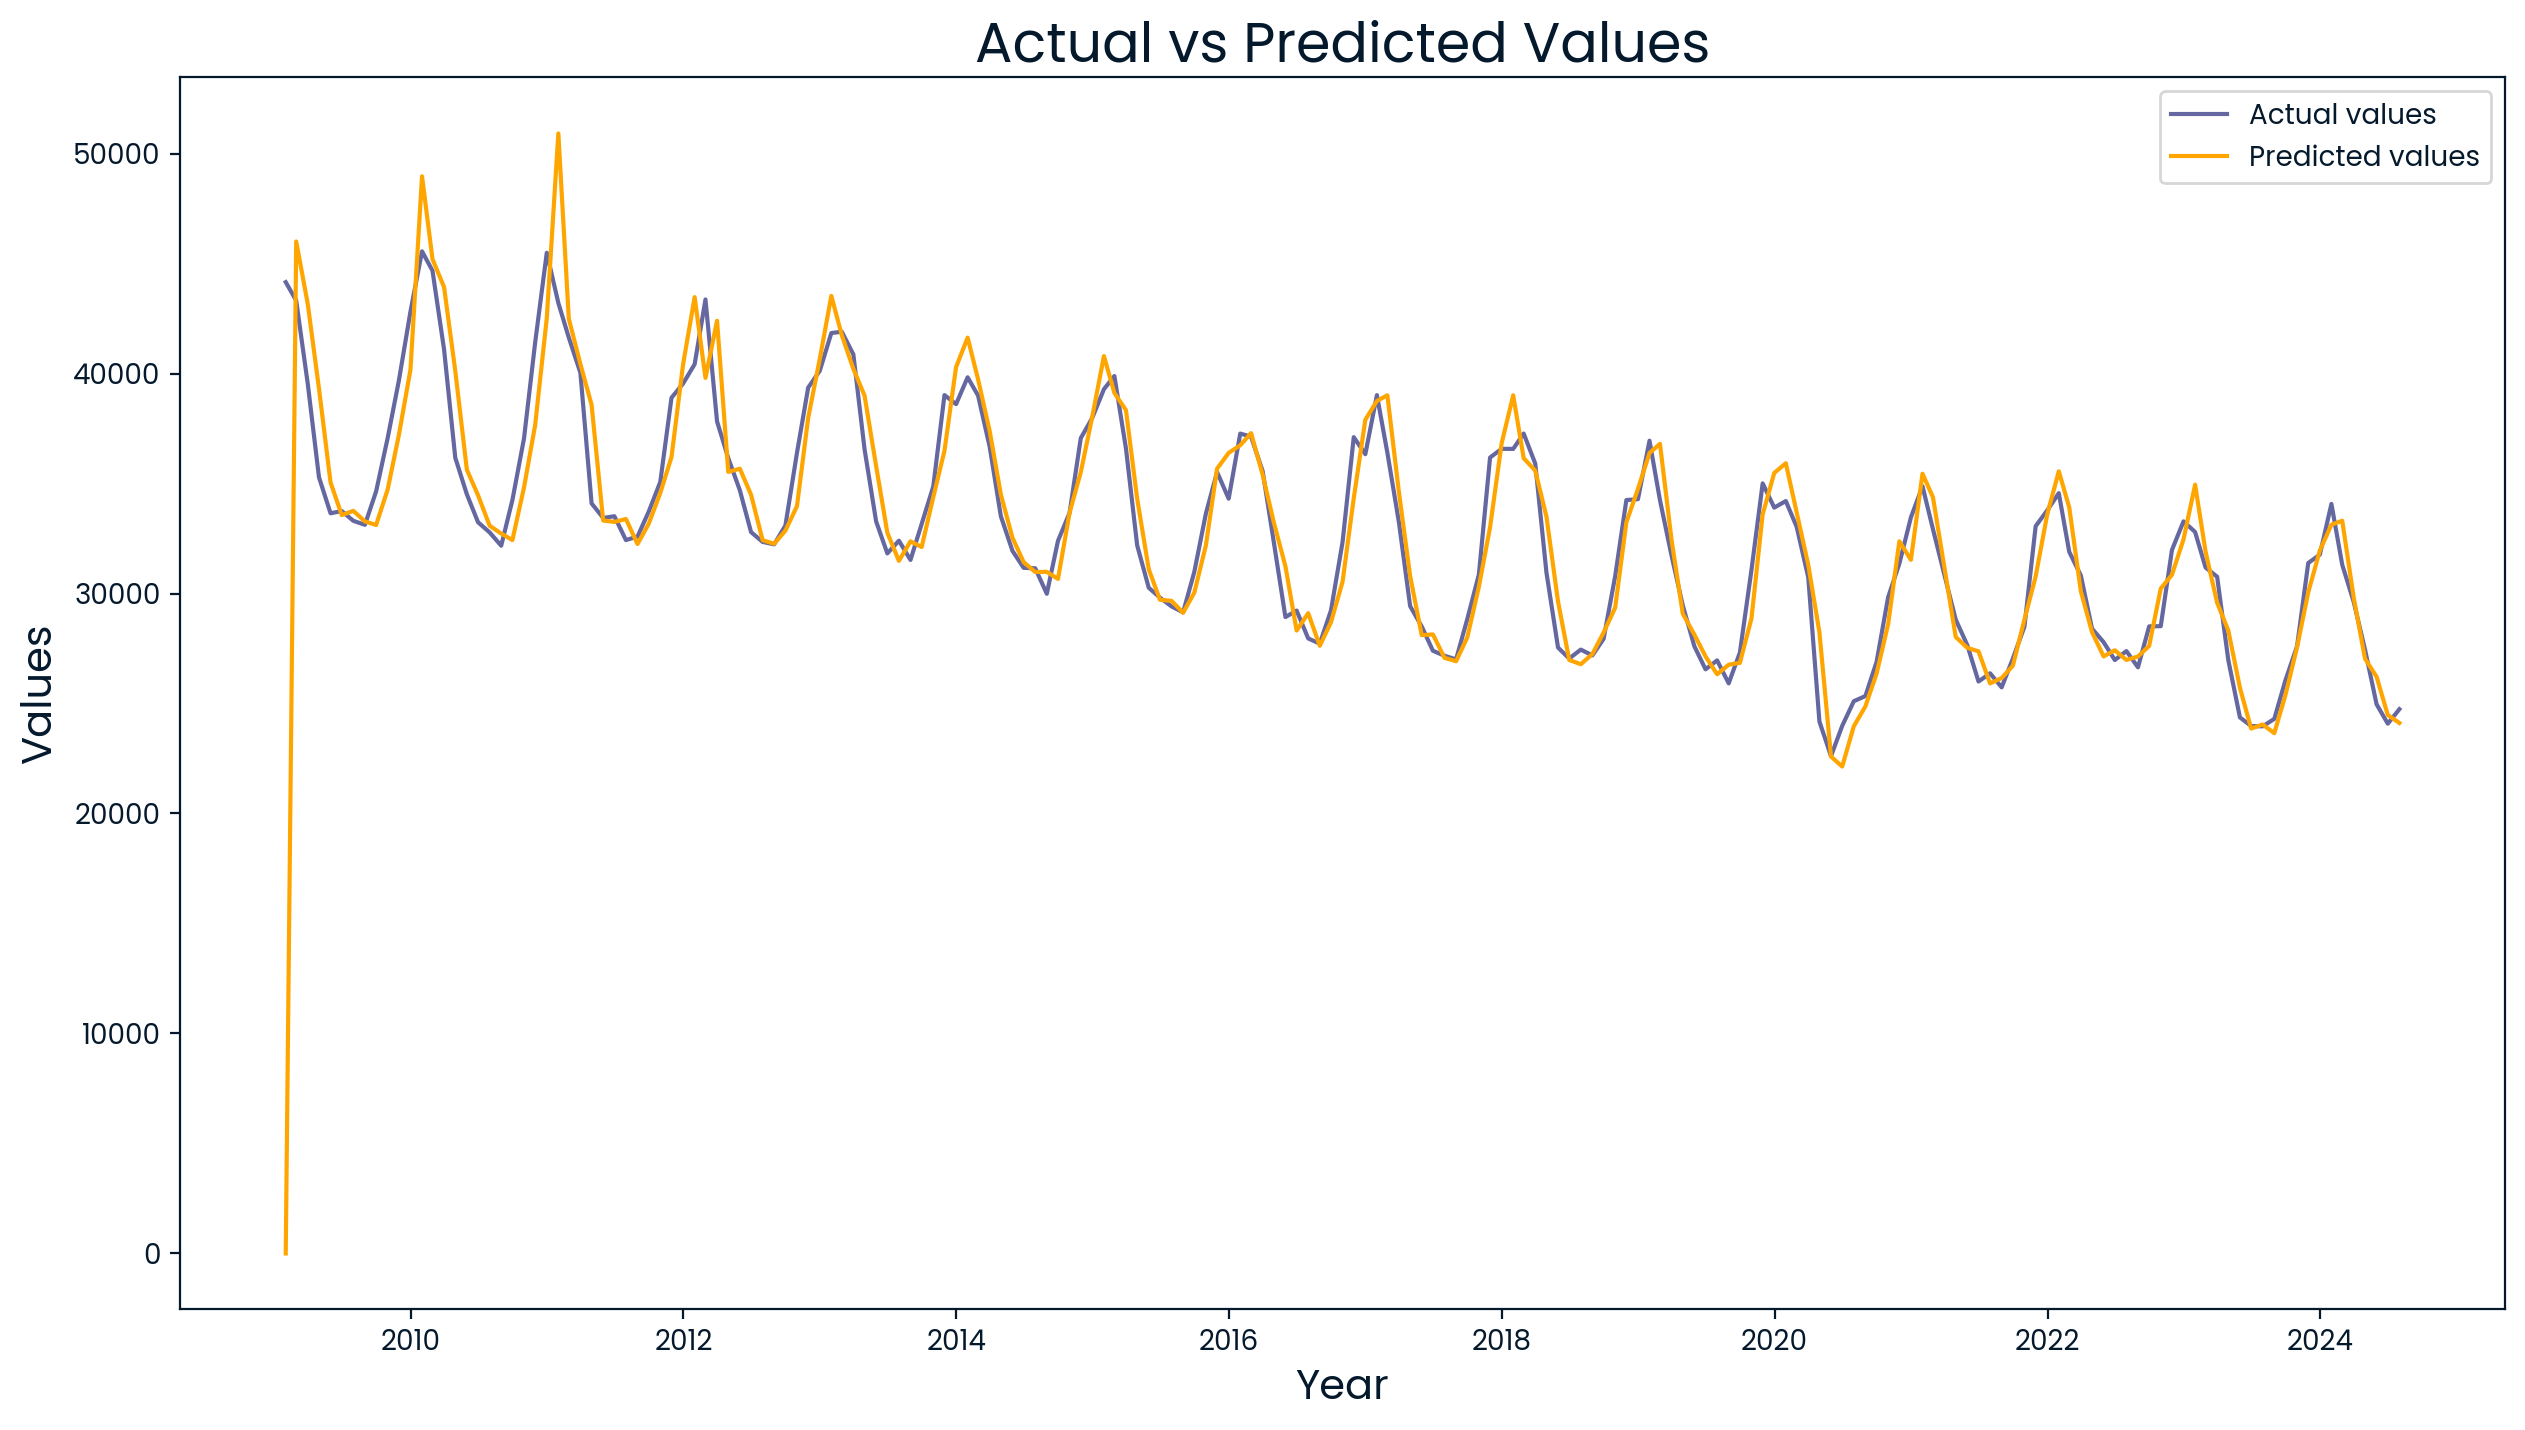

In [97]:
plt.figure(figsize=(15,8)) 
plt.plot(y.index,y,label='Actual values')
plt.plot(y.index,predictions, label='Predicted values', color='orange')
plt.xlabel('Year',fontsize=15)
plt.ylabel('Values',fontsize=15)
plt.title('Actual vs Predicted Values',fontsize=20)
plt.legend()
plt.show()

In [98]:
import statsmodels.api as sm
#Fit ARIMA model for 'nd'
model = sm.tsa.ARIMA(avg_month_nd['nd'], order=(0,1,1), seasonal_order=(1,0,1,12))
output = model.fit()
predictions = output.fittedvalues

output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                               nd   No. Observations:                  187
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1626.746
Date:                          Sat, 17 Aug 2024   AIC                           3261.492
Time:                                  07:58:02   BIC                           3274.395
Sample:                              01-31-2009   HQIC                          3266.721
                                   - 07-31-2024                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0711      0.023      3.050      0.002       0.025       0.117
ar.S.L12       0.9773      0.018     54.542      0.000       0.942       1.012
ma.S.L12      -0.8984      0.043    -21.004      0.000      -0.982      -0.815
sigma2      1.948e+06   4.77e-09   4.08e+14      0.000    1.95e+06    1.95e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.13   Jarque-Bera (JB):                40.38
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+30. Standard errors may be unstable.
"""

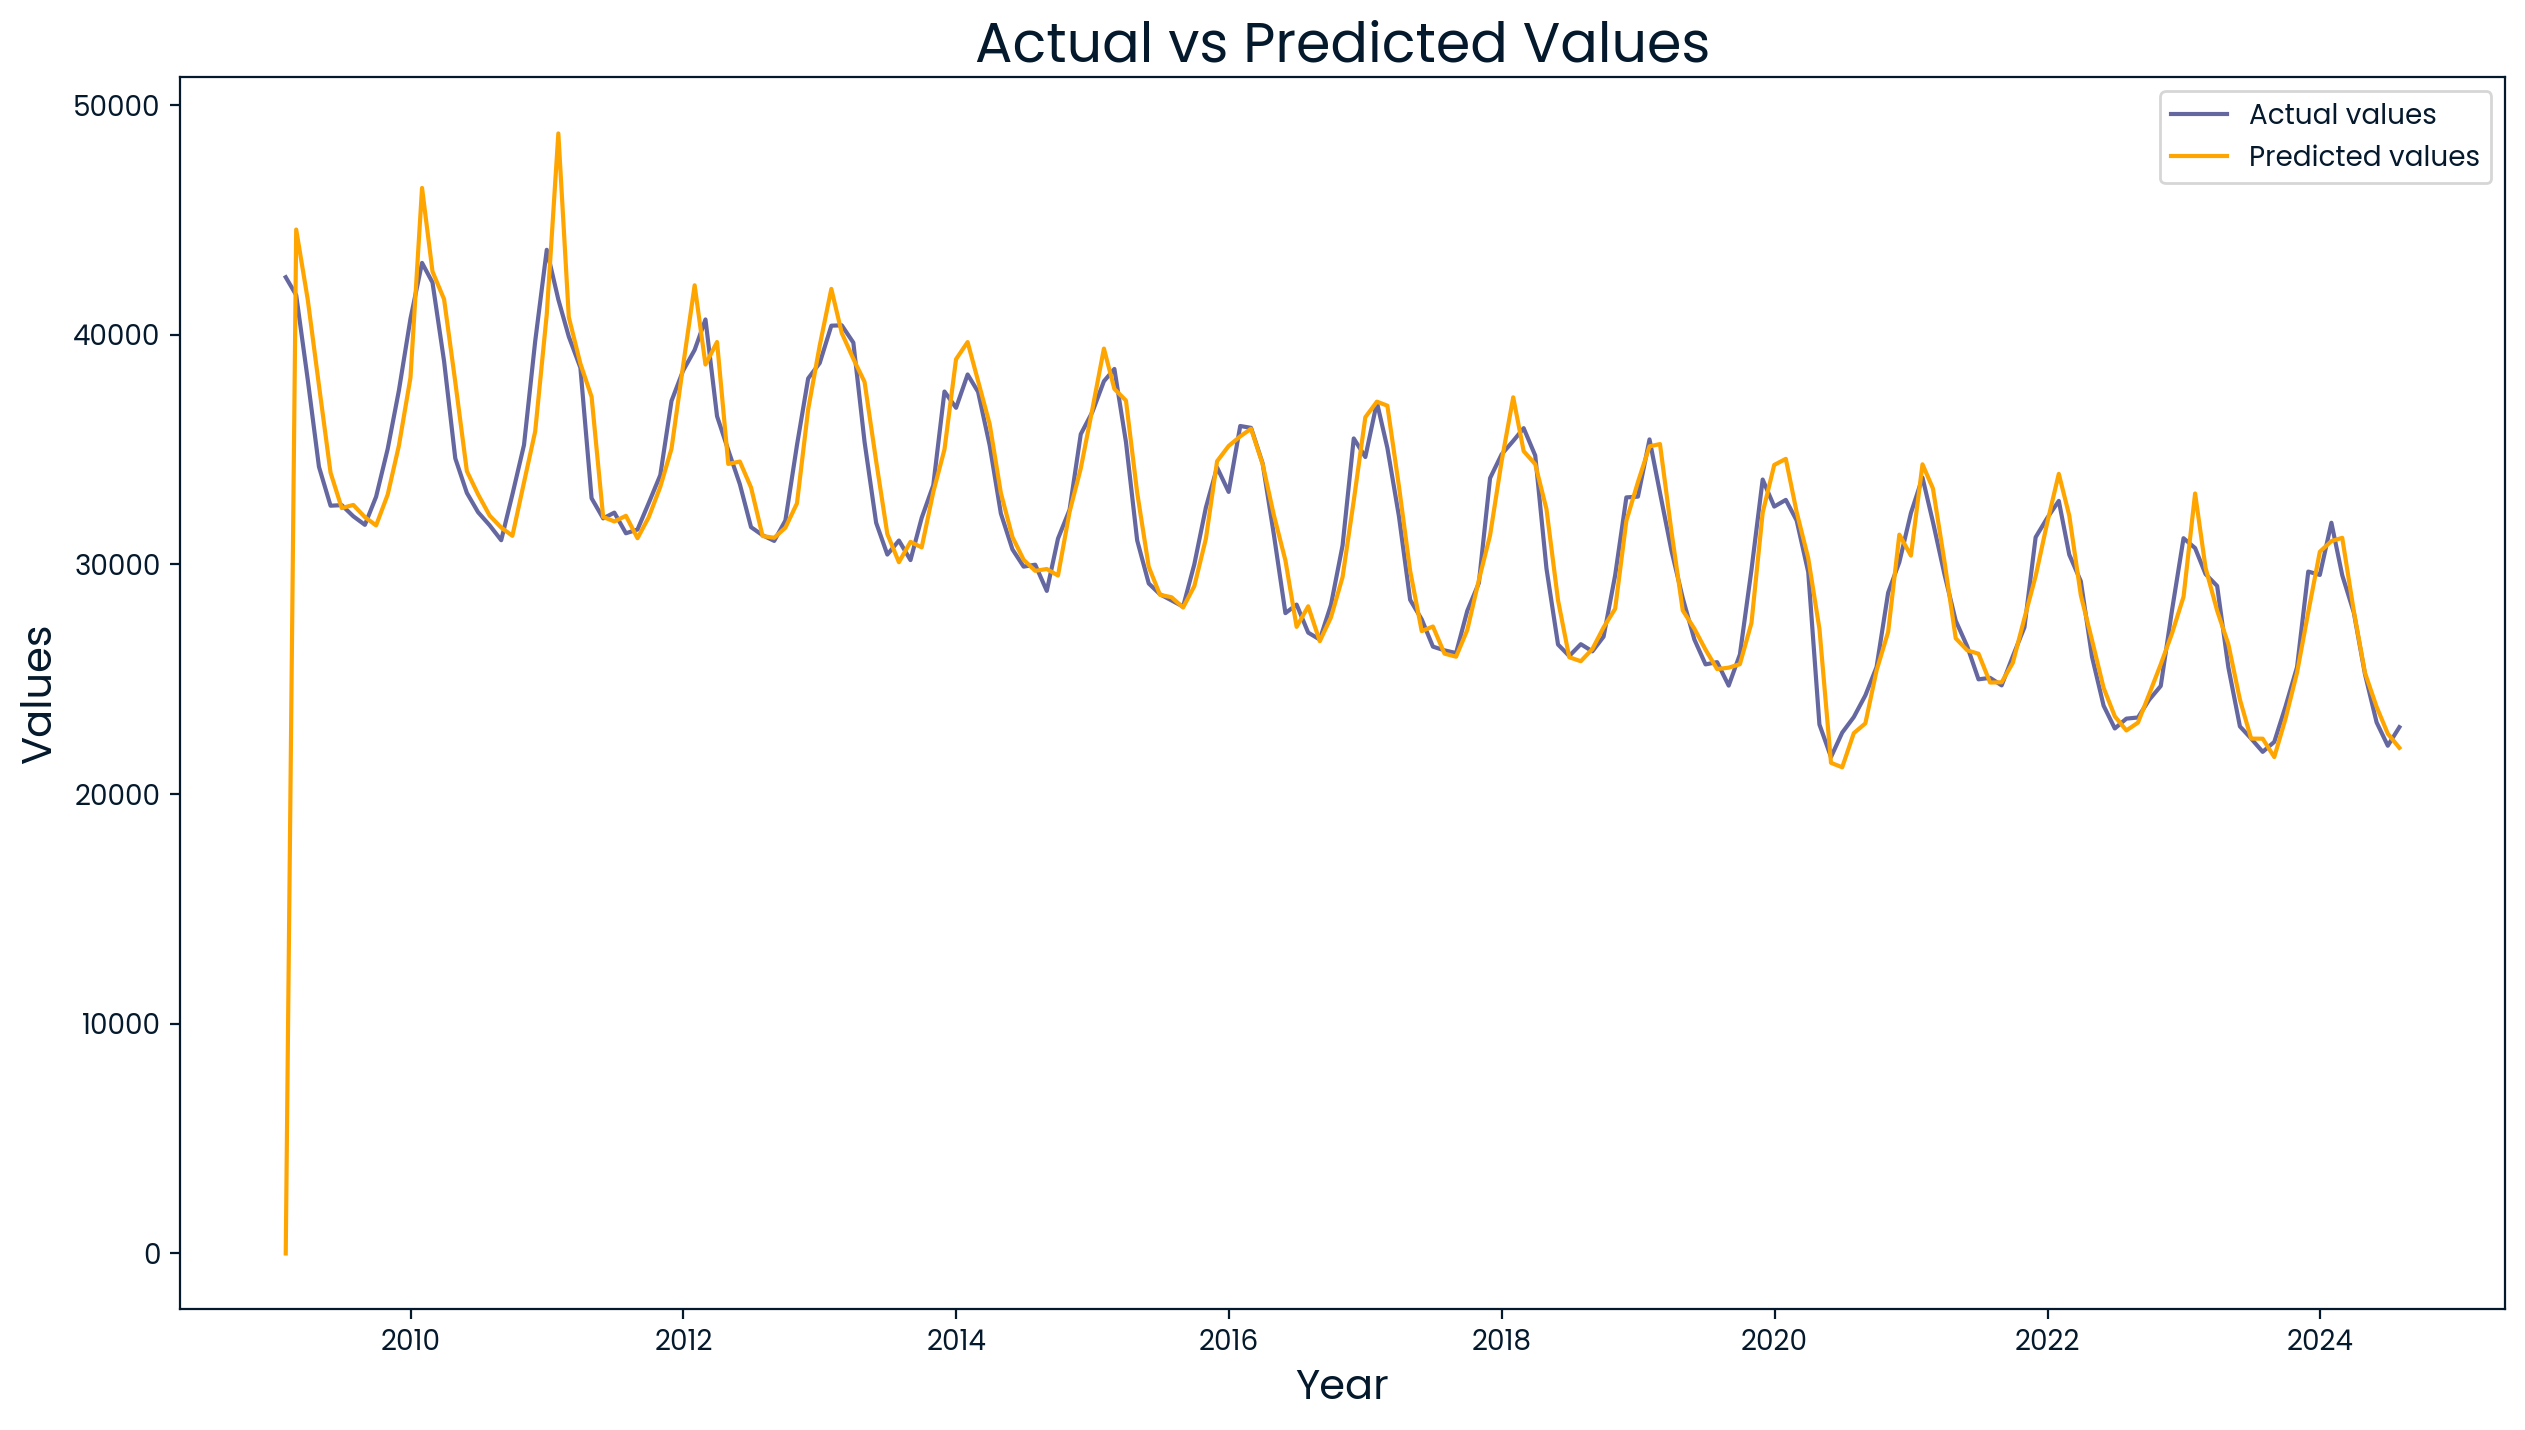

In [99]:
y = avg_month_nd['nd']
residuals = y - predictions
plt.figure(figsize=(15,8)) 
plt.plot(y.index,y,label='Actual values')
plt.plot(y.index,predictions, label='Predicted values', color='orange')
plt.xlabel('Year',fontsize=15)
plt.ylabel('Values',fontsize=15)
plt.title('Actual vs Predicted Values',fontsize=20)
plt.legend()
plt.show()

In [100]:
# Fitting SARIMA
sarima = SARIMAX(avg_month['tsd'], order=(1,1,1), seasonal_order=(1,1,0,12))
result = sarima.fit()
predictions = result.predict()
result.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58195D+00    |proj g|=  9.13646D-01

At iterate    5    f=  8.15499D+00    |proj g|=  4.21744D-03

At iterate   10    f=  8.15432D+00    |proj g|=  8.33528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   3.607D-05   8.154D+00
  F =   8.1542867962022658     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 tsd   No. Observations:                  187
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1524.852
Date:                             Sat, 17 Aug 2024   AIC                           3057.703
Time:                                     07:58:04   BIC                           3070.339
Sample:                                 01-31-2009   HQIC                          3062.829
                                      - 07-31-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4934      0.238      2.076      0.038       0.028       0.959
ma.L1         -0.6183      0.233     -2.651      0.008      -1.075      -0.161
ar.S.L12      -0.0918      0.016     -5.855      0.000      -0.122      -0.061
sigma2      2.416e+06   2.42e+05      9.994      0.000    1.94e+06    2.89e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.35   Jarque-Bera (JB):                33.88
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.20
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

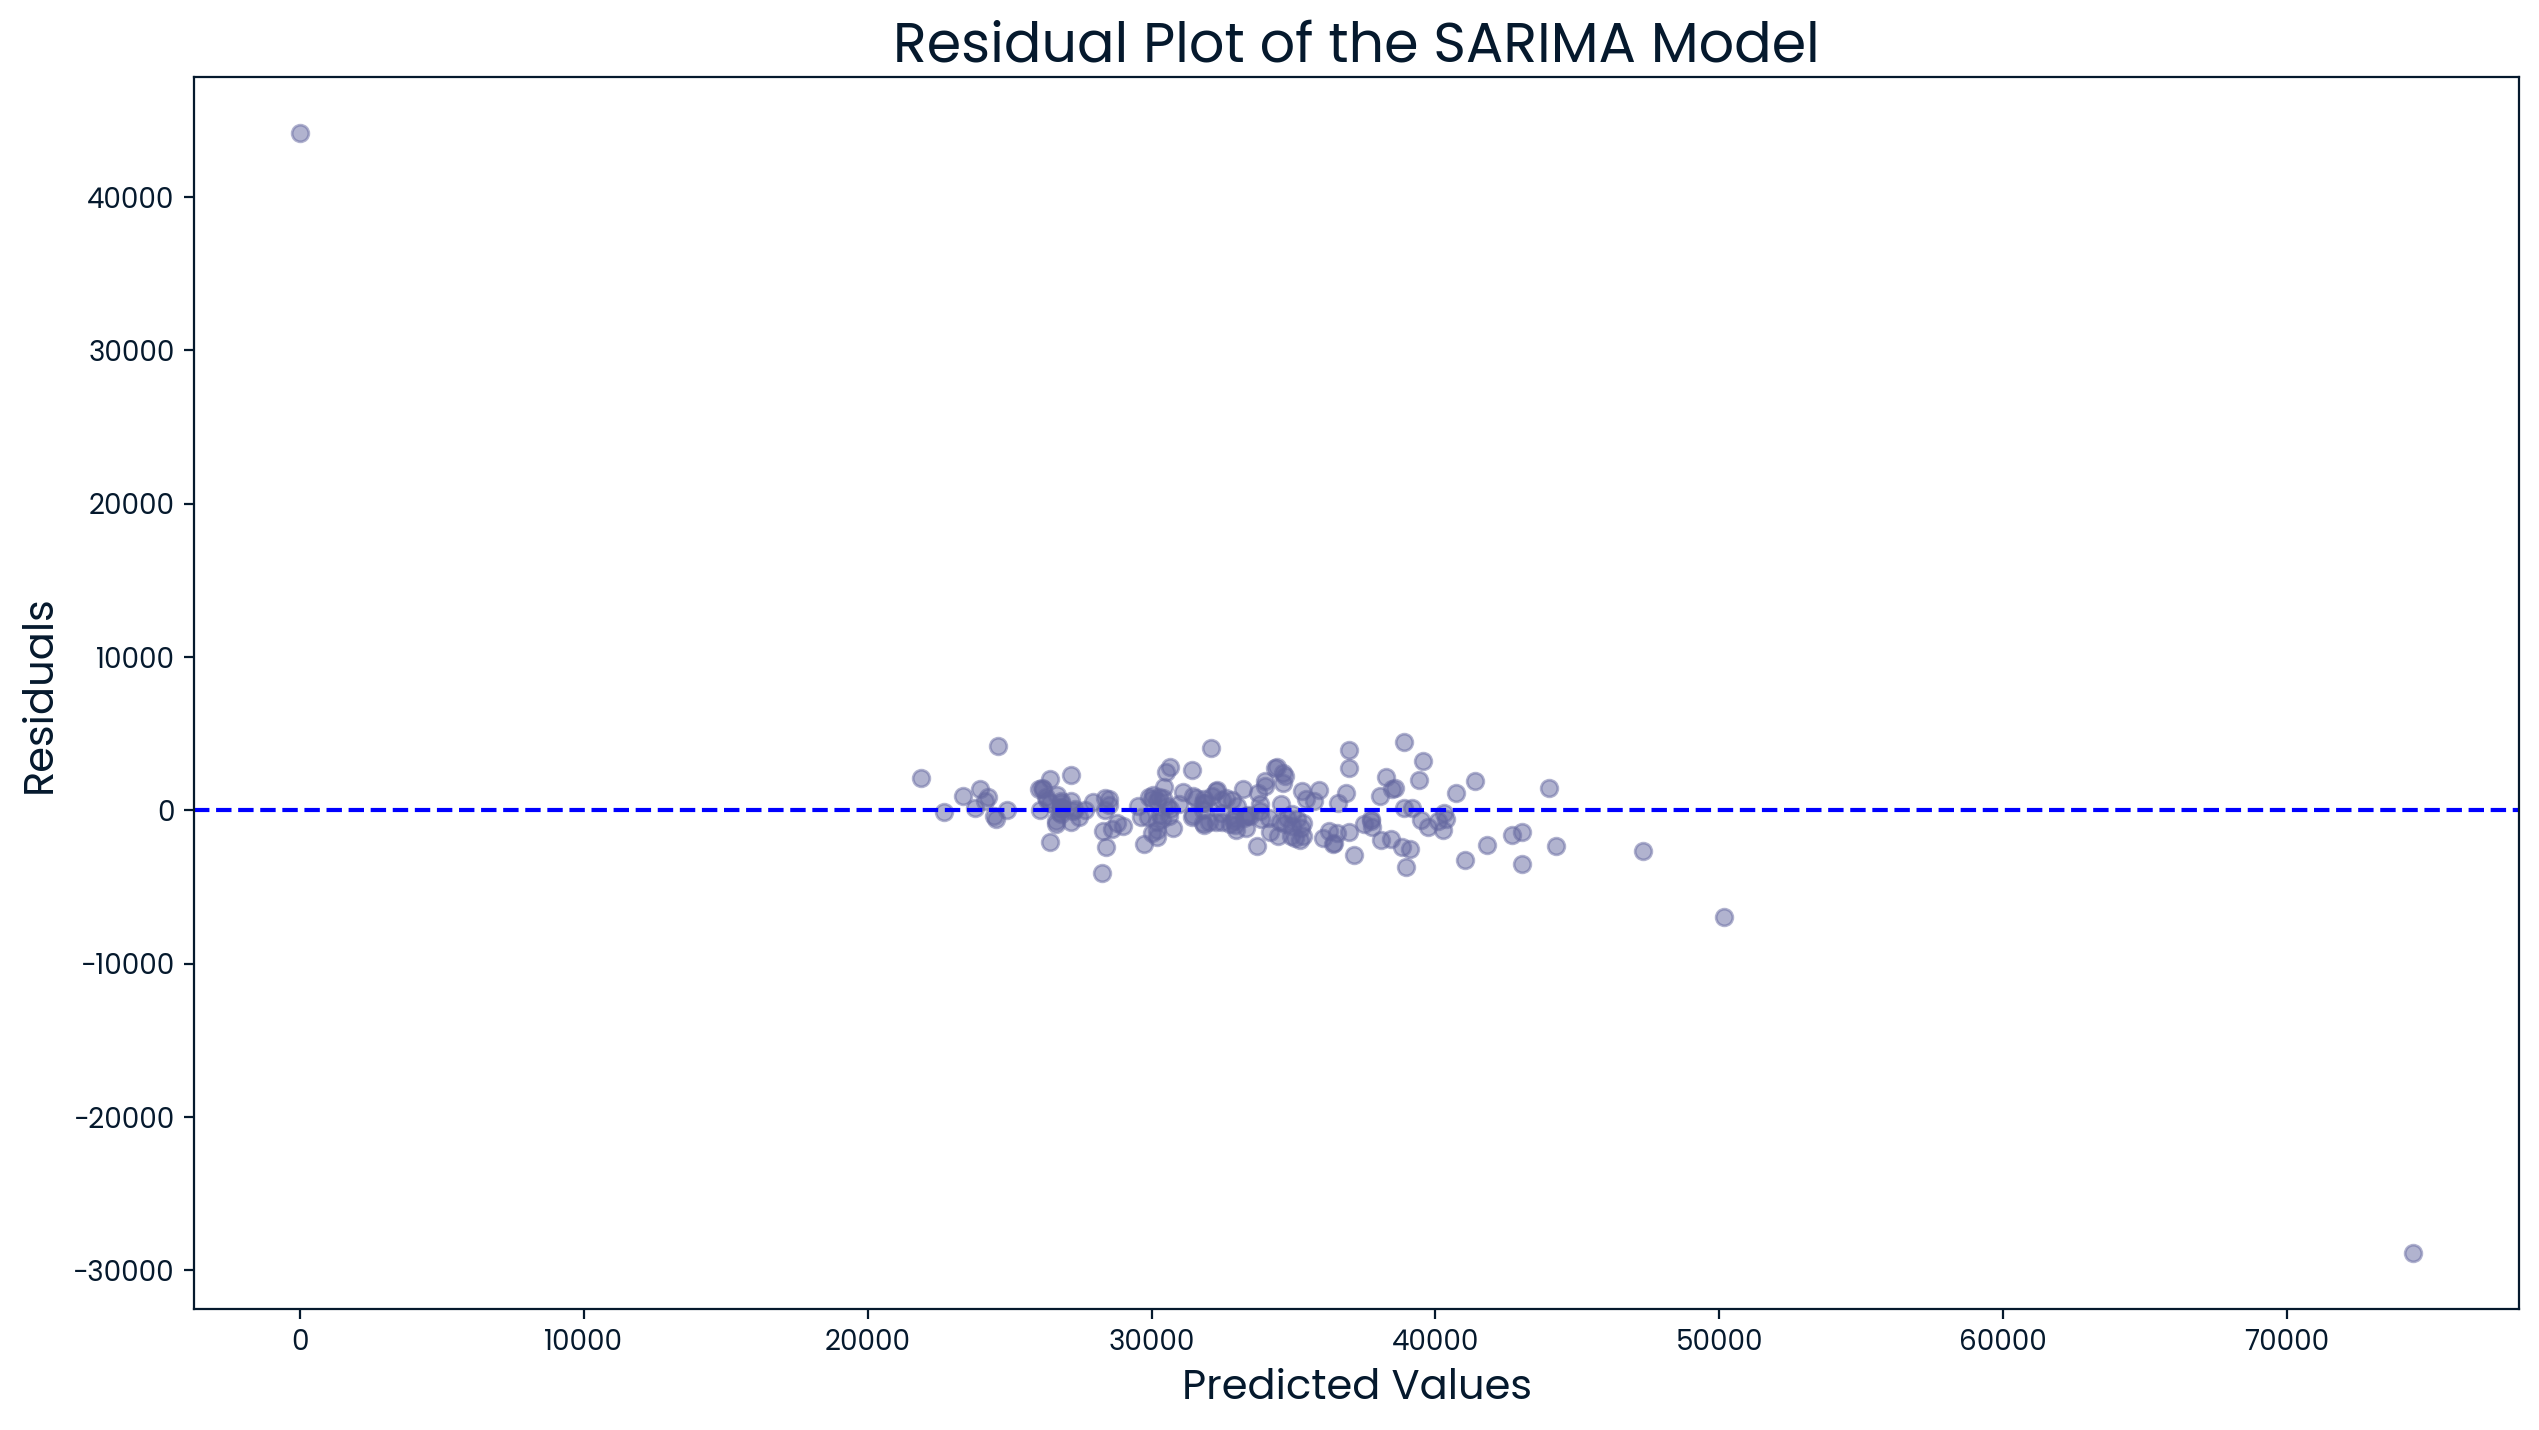

In [101]:
y = avg_month['tsd']
residuals = y - predictions

#residual plot of the SARIMA model
plt.figure(figsize=(15,8))
plt.scatter(predictions,residuals, alpha=0.5)
plt.axhline(0, color = 'blue', linestyle='--')
plt.xlabel('Predicted Values',fontsize=15)
plt.ylabel('Residuals',fontsize=15)
plt.title('Residual Plot of the SARIMA Model',fontsize=20)
plt.show()

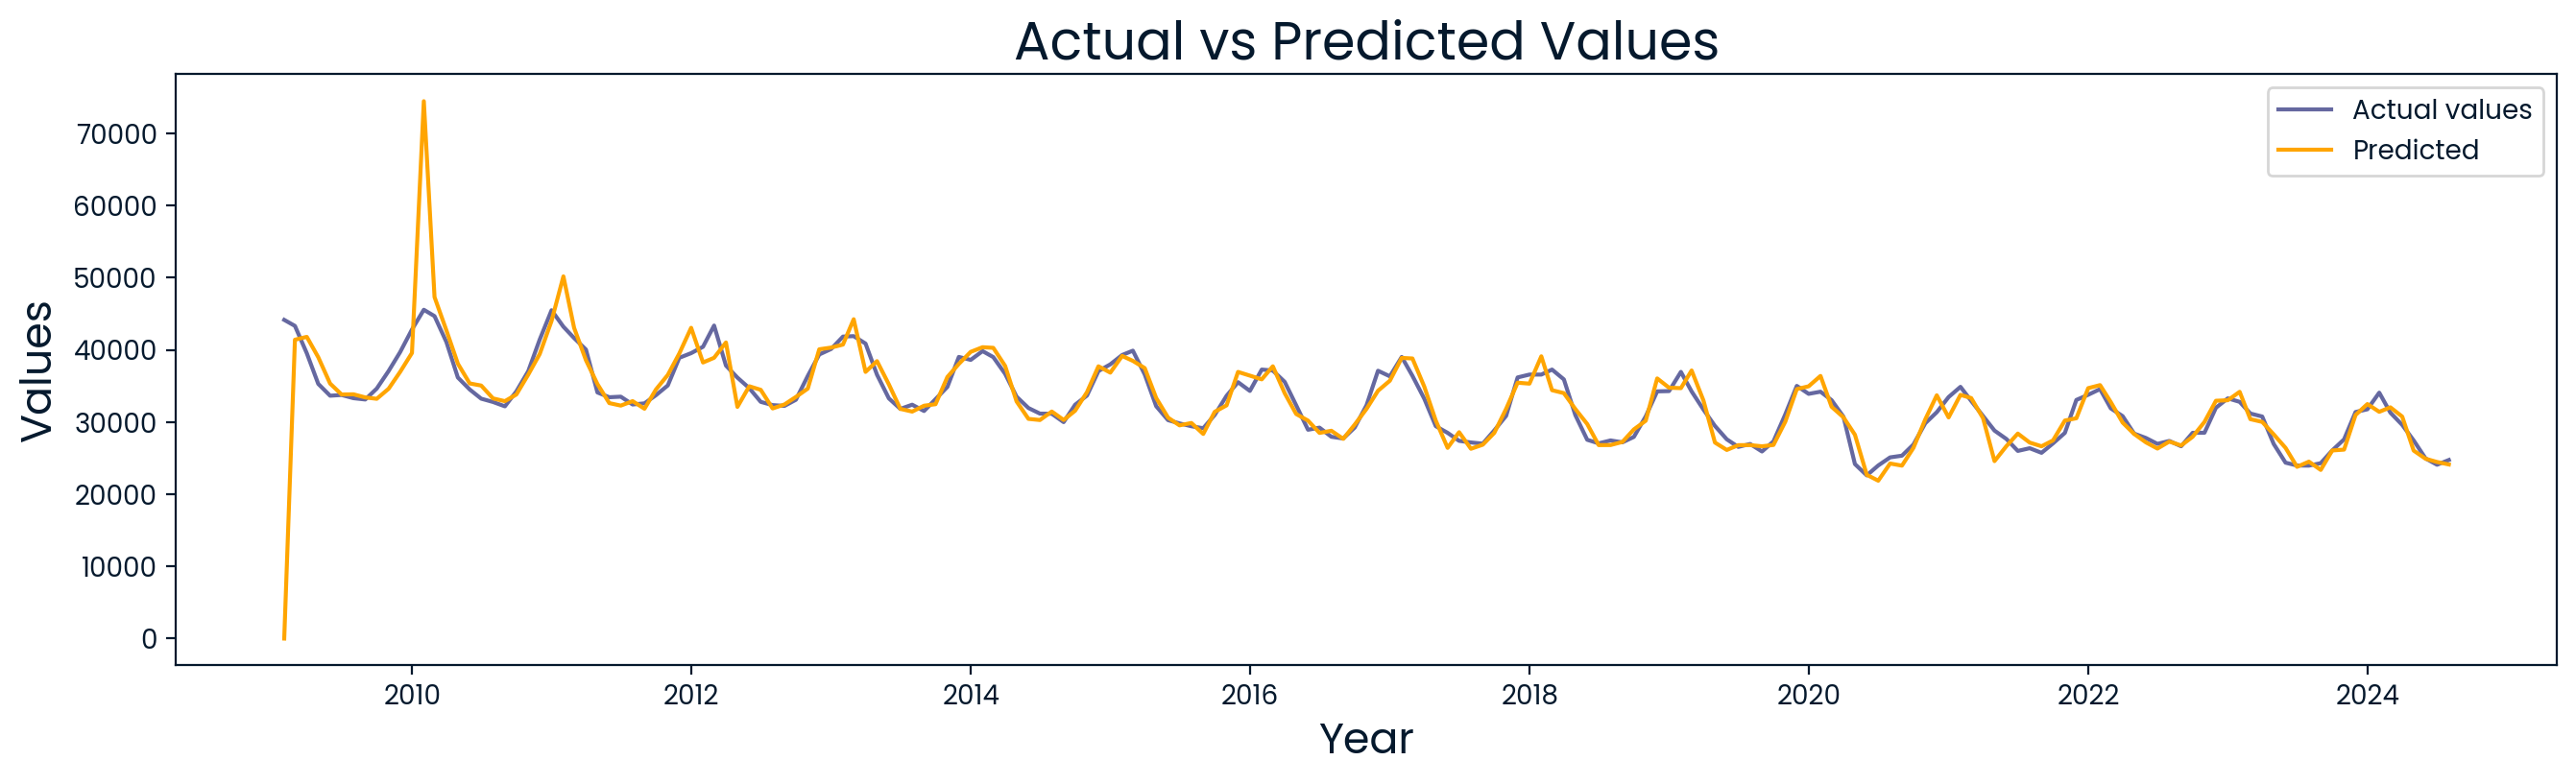

In [102]:

plt.figure(figsize=(16,4))
plt.plot(y.index,y,label='Actual values')
plt.plot(predictions, label="Predicted", color = 'orange')
plt.title('Actual vs Predicted Values', fontsize=20)
plt.ylabel('Values', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.legend()

In [103]:
# Fitting SARIMA for 'ND'
sarima = SARIMAX(avg_month_nd['nd'], order=(1,1,1), seasonal_order=(1,1,0,12))
result = sarima.fit()
predictions = result.predict()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55889D+00    |proj g|=  8.75688D-01


 This problem is unconstrained.



At iterate    5    f=  8.10198D+00    |proj g|=  3.73247D-03

At iterate   10    f=  8.10130D+00    |proj g|=  2.87559D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   4.845D-05   8.101D+00
  F =   8.1012922167663604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  nd   No. Observations:                  187
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1514.942
Date:                             Sat, 17 Aug 2024   AIC                           3037.883
Time:                                     07:58:07   BIC                           3050.520
Sample:                                 01-31-2009   HQIC                          3043.009
                                      - 07-31-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5439      0.227      2.398      0.016       0.099       0.988
ma.L1         -0.6739      0.221     -3.053      0.002      -1.107      -0.241
ar.S.L12      -0.1059      0.016     -6.647      0.000      -0.137      -0.075
sigma2      2.171e+06    2.3e+05      9.421      0.000    1.72e+06    2.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.05   Jarque-Bera (JB):                32.50
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.29
Prob(H) (two-sided):                  0.21   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

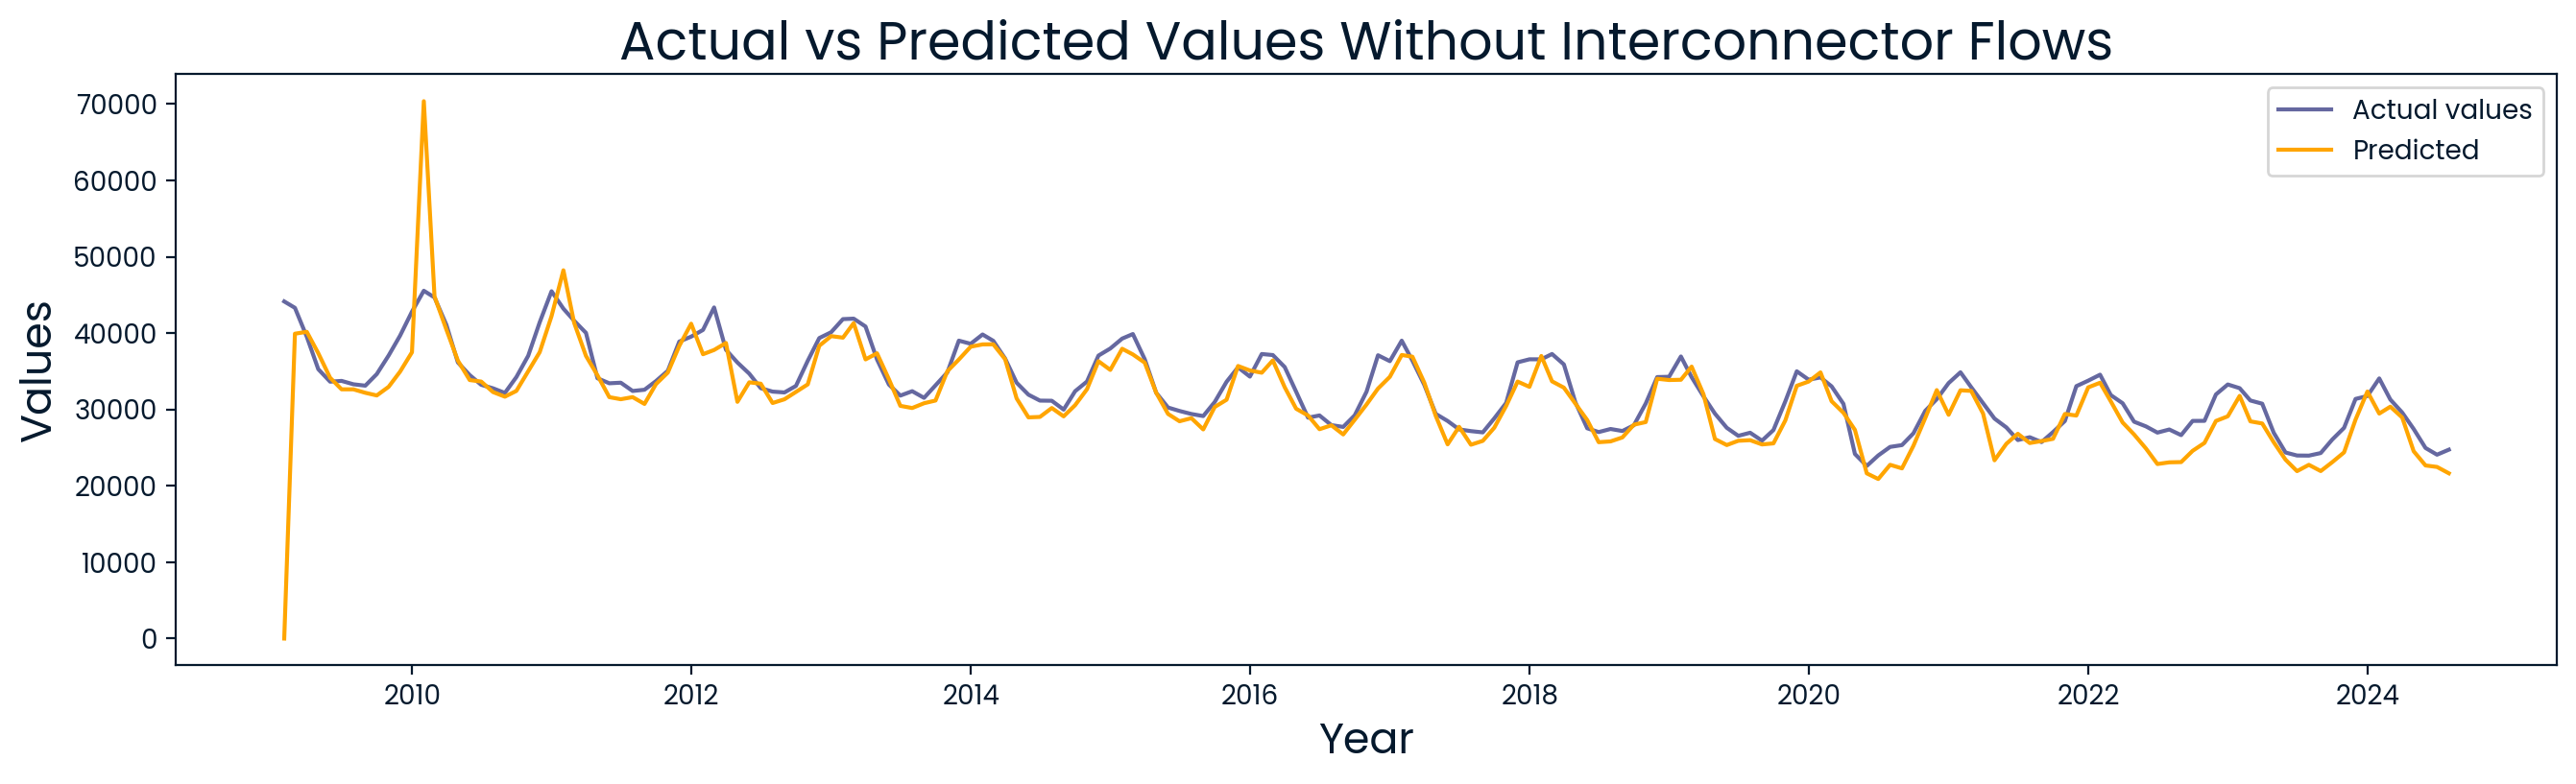

In [104]:
plt.figure(figsize=(16,4))
plt.plot(y.index,y,label='Actual values')
plt.plot(predictions, label="Predicted", color = 'orange')
plt.title('Actual vs Predicted Values Without Interconnector Flows', fontsize=20)
plt.ylabel('Values', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.legend()

In [105]:
#Subset of the dataframe containing the interconnector flows and weather components. 

intercon_df = energy_sub[['tsd','embedded_wind_generation','embedded_wind_capacity','embedded_solar_capacity','ifa_flow','ifa2_flow','britned_flow','moyle_flow','east_west_flow','nemo_flow']]

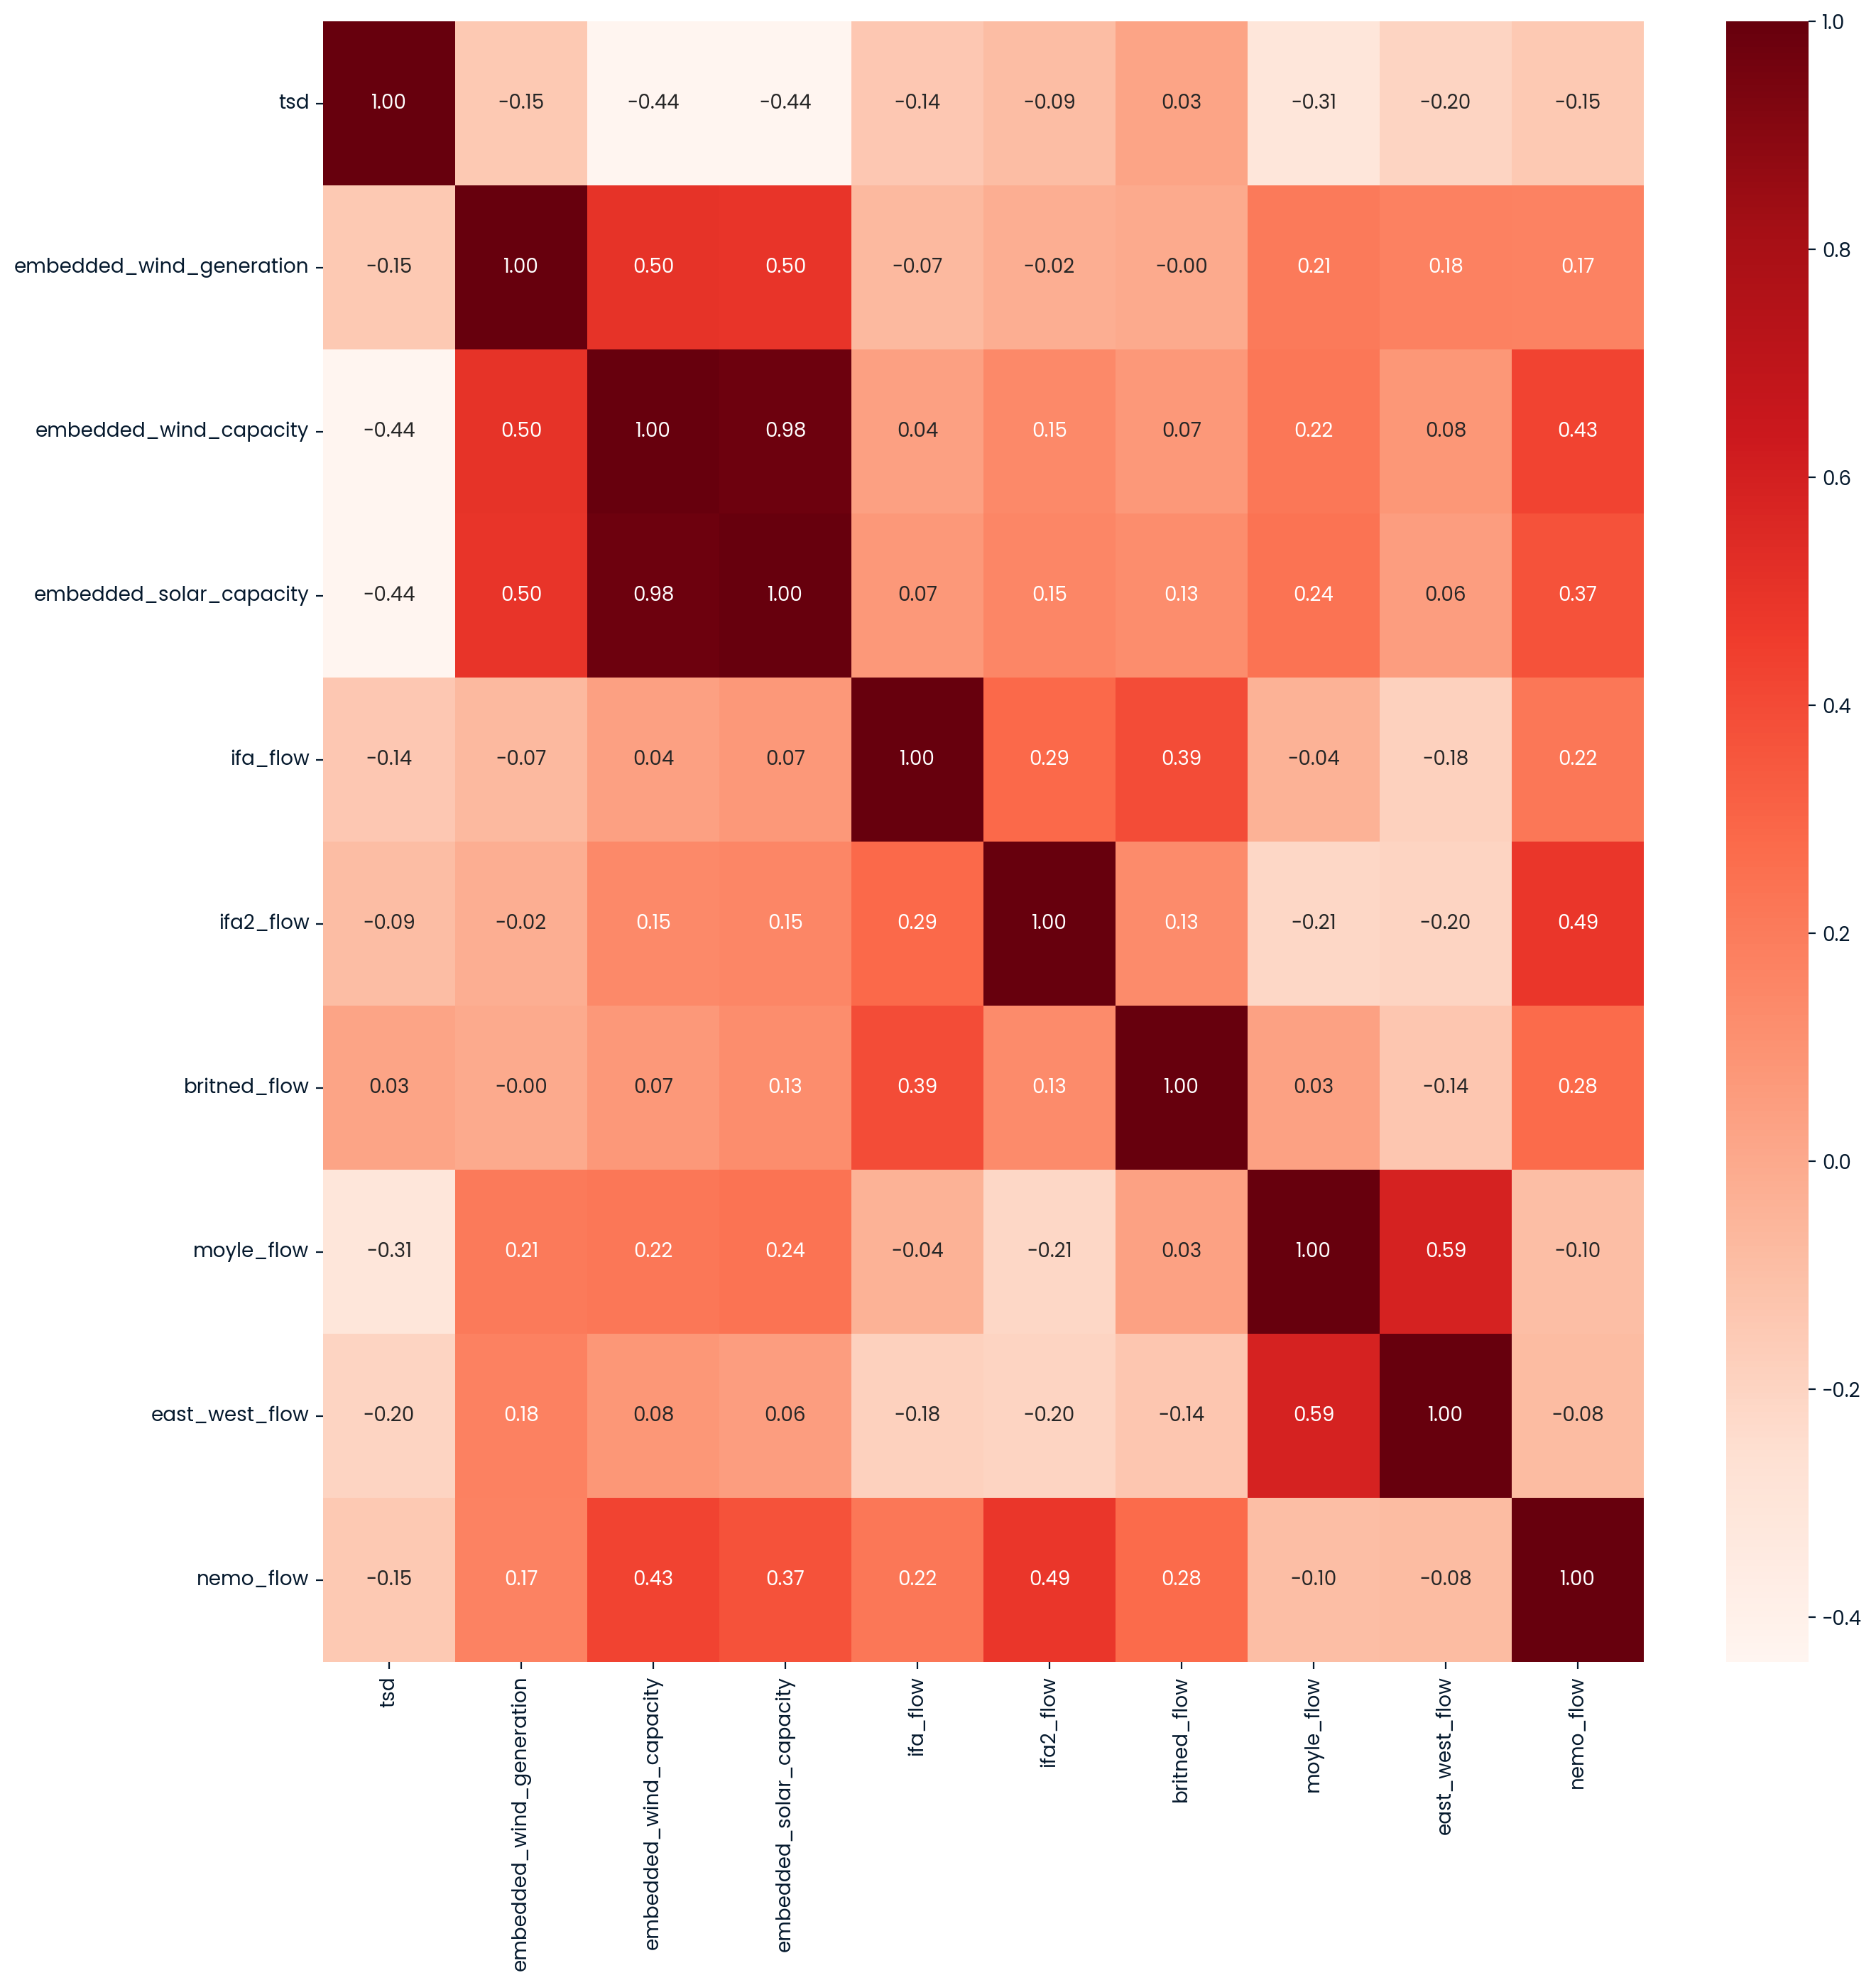

In [106]:
#Heat Map
plt.figure(figsize=(15,15))
sns.heatmap(intercon_df.corr(), annot=True,cmap='Reds', fmt='.2f')
plt.show()

In [107]:
# Choosing features based on the correlation with the target variable and between features
intercon_df = energy_sub[['tsd','embedded_wind_generation','embedded_wind_capacity','embedded_solar_capacity','ifa_flow','ifa2_flow','britned_flow','moyle_flow','east_west_flow','nemo_flow']]

newflow_data = intercon_df[['tsd','embedded_wind_capacity','moyle_flow','ifa_flow','ifa2_flow','britned_flow','nemo_flow']]

In [108]:
#Subset for import and export values
imports_data = newflow_data[(newflow_data['ifa_flow']>0) | (newflow_data['ifa2_flow']>0)| (newflow_data['britned_flow']>0)| (newflow_data['moyle_flow']>0)|(newflow_data['nemo_flow']>0)]
 

#Subset for exports
exports_data = newflow_data[(newflow_data['ifa_flow']<0) | (newflow_data['ifa2_flow']<0)| (newflow_data['britned_flow']<0)| (newflow_data['moyle_flow']<0)|(newflow_data['nemo_flow']<0)]

In [109]:
#For import data
x_i = imports_data.drop('tsd',axis=1)
y_i = imports_data['tsd']

#split data into training and test set
x_train_i,x_test_i,y_train_i,y_test_i = train_test_split(x_i,y_i,random_state=42,test_size=0.3)

In [110]:
#For export data
x_e = exports_data.drop('tsd',axis=1)
y_e = exports_data['tsd']

#split data into training and test set
x_train_e,x_test_e,y_train_e,y_test_e = train_test_split(x_e,y_e,random_state=42,test_size=0.3)

In [111]:
# Function for creating Linear Regression model using Statsmodel
def reg_Model(x, y):
    constant = sm.add_constant(x)
    model = sm.OLS(y, constant).fit()
    print(model.summary())
    
    
#model for Imports
reg_Model(x_train_i,y_train_i)

                            OLS Regression Results                            
Dep. Variable:                    tsd   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     8188.
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        07:58:08   Log-Likelihood:            -1.7716e+06
No. Observations:              173989   AIC:                         3.543e+06
Df Residuals:                  173982   BIC:                         3.543e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3.66

In [112]:
#model for exports
reg_Model(x_train_e,y_train_e)

                            OLS Regression Results                            
Dep. Variable:                    tsd   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     9069.
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        07:58:09   Log-Likelihood:            -1.4823e+06
No. Observations:              145096   AIC:                         2.965e+06
Df Residuals:                  145089   BIC:                         2.965e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3.88

In [113]:
#For Britned Interconnector flow only for imports
x_brit = x_train_i['britned_flow']
y = y_train_i

#model for exports
reg_Model(x_brit,y)

                            OLS Regression Results                            
Dep. Variable:                    tsd   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2842.
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        07:58:09   Log-Likelihood:            -1.7918e+06
No. Observations:              173989   AIC:                         3.584e+06
Df Residuals:                  173987   BIC:                         3.584e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          3.12e+04     26.125   1194.414   

In [114]:
# Function to evaluate model performance
def eval_model(x, y):
    constant = sm.add_constant(x)
    model = sm.OLS(y, constant).fit()
    y_pred = model.predict(constant)
    resids = y - y_pred

    # Calculating the Mean Squared Error (MSE)
    mse = np.mean(resids**2)

    #calculate the MAE
    mae = mean_absolute_error(y,y_pred)
    print(f'Mean Absolute Error: {mae}')
    
    # Calculating the RMSE
    rmse = np.sqrt(mse)

    print(f'RMSE: {rmse}')

# Function for Residual plot
def resid_plot(x, y):
    constant = sm.add_constant(x)
    model = sm.OLS(y, constant).fit()
    # Predict values with model
    y_pred = model.predict(constant)
    # Calculate residuals
    resids = y - y_pred

    # Residual Plot
    plt.figure(figsize=(10,6))
    sns.displot(resids, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.show()

# Function for Predicted vs Actual Values plot
def pred_Actual_plot(x, y):
    constant = sm.add_constant(x)
    model = sm.OLS(y, constant).fit()
    # Predict values with model
    y_pred = model.predict(constant)
    # Predicted Versus Actual Values Plot
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=y, y=y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='r', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted Values vs Actual Values')
    plt.show()
    
    
# Function for Predicted vs Actual Values plot
def pred_Actual_plot2(x, y):
    constant = sm.add_constant(x)
    model = sm.OLS(y, constant).fit()
    # Predict values with model
    y_pred = model.predict(constant)  
    fig=plt.figure()
    plt.scatter(y,y_pred)
    fig.suptitle('Actual vs Predicted Values',fontsize=20)
    plt.xlabel('Actual',fontsize=18)
    plt.ylabel('Predicted',fontsize=16)

In [115]:
#Evaluate model performance for imports 
eval_model(x_test_i,y_test_i)

Mean Absolute Error: 5171.2050964531645
RMSE: 6397.870055429902


In [116]:
#Evaluate model performance for exports 
eval_model(x_test_e,y_test_e)

Mean Absolute Error: 5350.057703652943
RMSE: 6609.940104066262


<Figure size 1000x600 with 0 Axes>

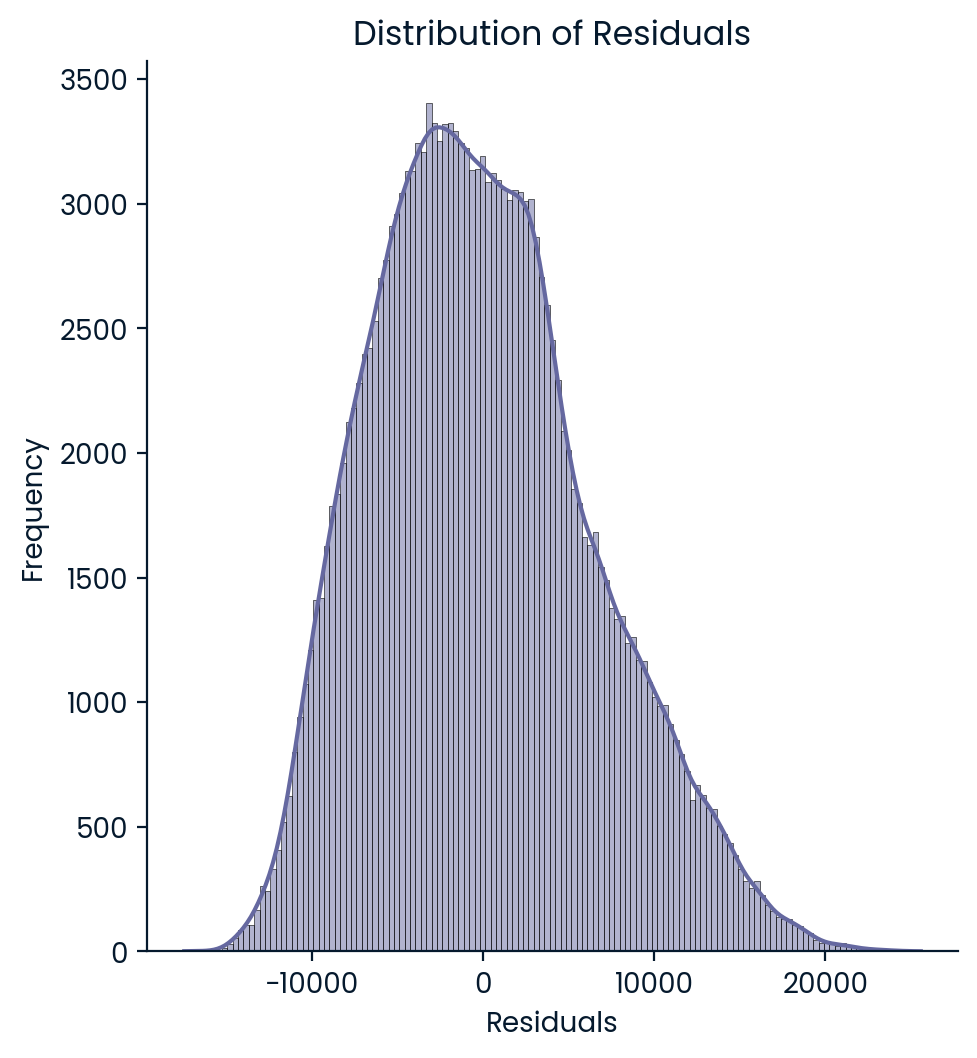

In [117]:
#Residual plot for Imports
resid_plot(x_train_i, y_train_i)

<Figure size 1000x600 with 0 Axes>

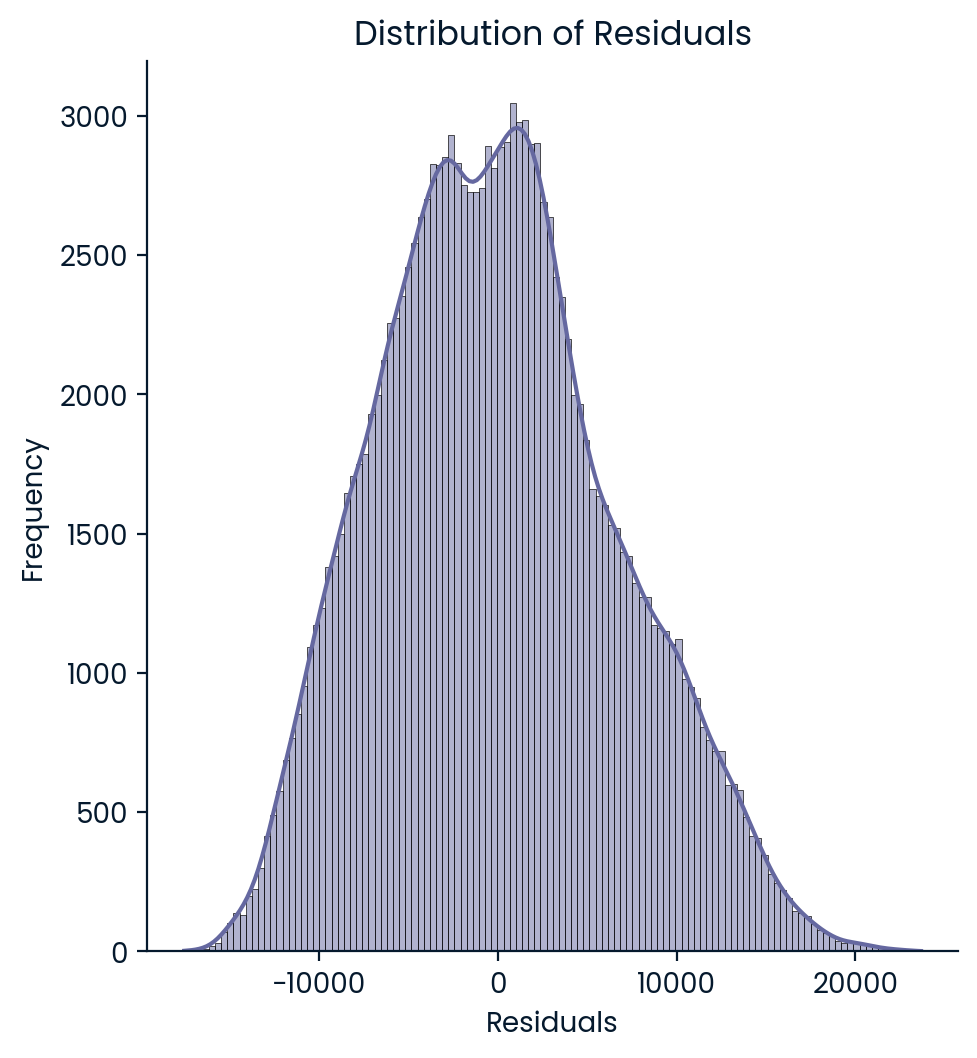

In [118]:
#Residual plot for Exports
resid_plot(x_train_e, y_train_e)

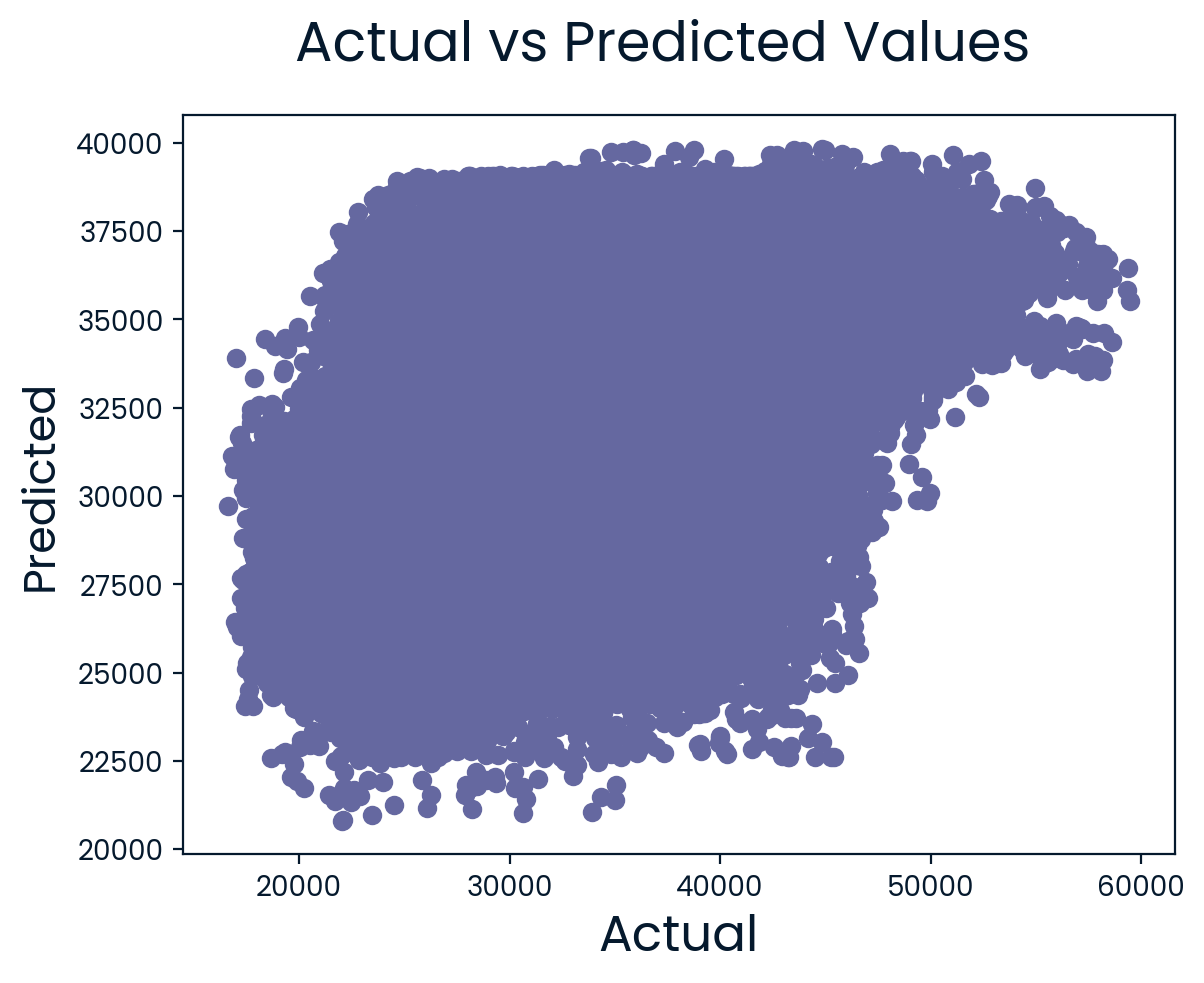

In [119]:
#Predicted vs Actual Value plot for Imports
pred_Actual_plot2(x_test_i, y_test_i)

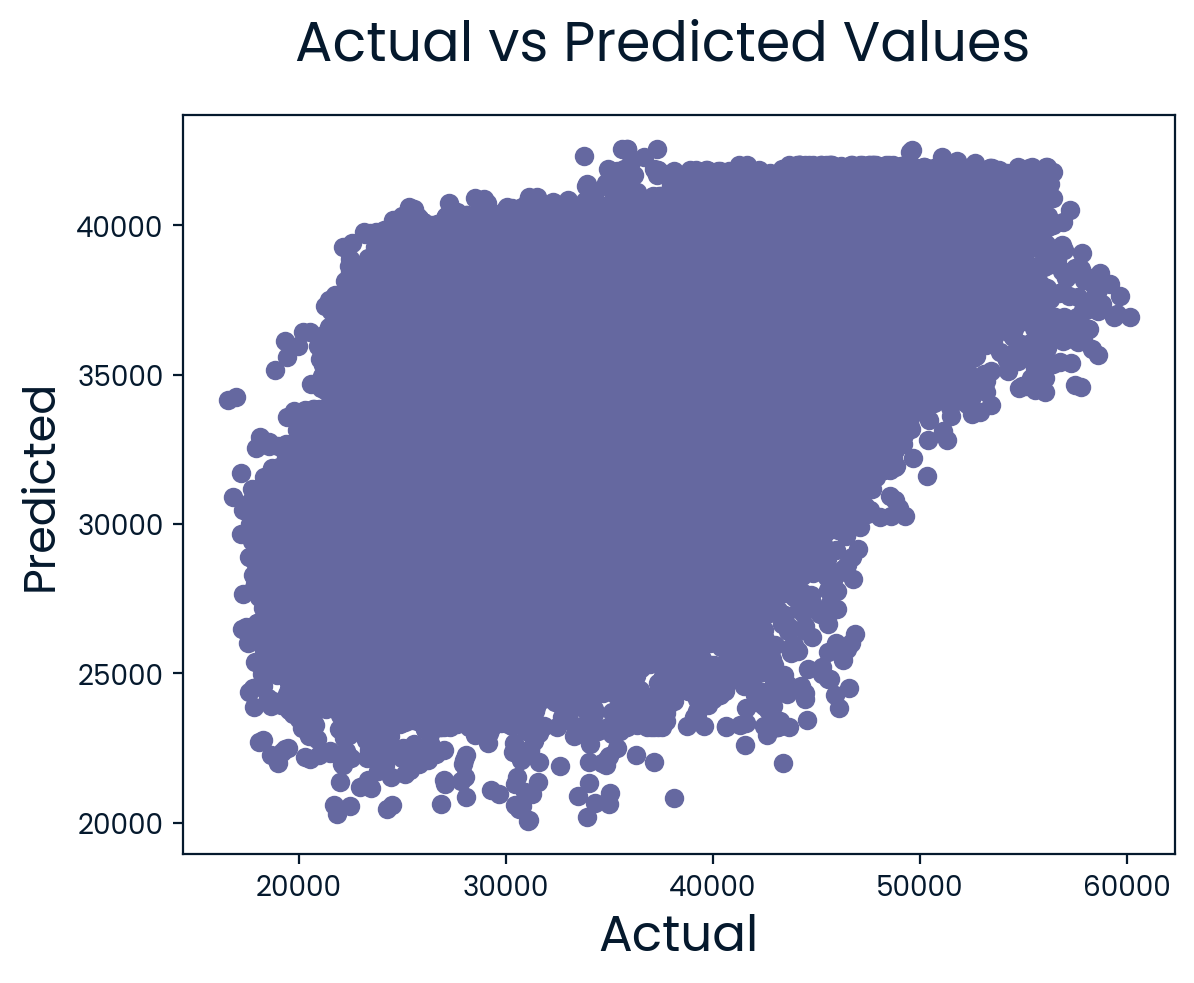

In [120]:
#Predicted vs Actual Value plot for exports
pred_Actual_plot2(x_test_e, y_test_e)